In [1]:
import drawing
import imp
imp.reload(drawing)

<module 'drawing' from '/u/home/lyrebird_code/handwriting_synthesis/drawing.py'>

In [2]:
import numpy as np

import os

import torch

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)


cuda:0


In [3]:
import matplotlib.pyplot as plt

def offsets_to_coords(offsets):
    """
    convert from offsets to coordinates
    """
    return np.concatenate([np.cumsum(offsets[:, :2], axis=0), offsets[:, 2:3]], axis=1)


def draw(offsets, plot_end_points=True):
    strokes = offsets_to_coords(offsets)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    stroke = []
    for x, y, eos in strokes:
        stroke.append((x, y))
        if eos == 1:
            coords = list(zip(*stroke))
            ax.plot(coords[0], coords[1], 'k')
            if plot_end_points:
                ax.plot(x, y, 'ro')
            stroke = []
    if stroke:
        coords = list(zip(*stroke))
        ax.plot(coords[0], coords[1], 'k')
        stroke = []

    padding = 10
    
    ax.set_xlim(strokes[:,0].min() - padding, strokes[:,0].max() + padding)
    ax.set_ylim(strokes[:,1].min() - padding, strokes[:,1].max() + padding)

    ax.set_aspect('equal')
    plt.tick_params(
        axis='both',
        left='off',
        top='off',
        right='off',
        bottom='off',
        labelleft='off',
        labeltop='off',
        labelright='off',
        labelbottom='off'
    )
    plt.show()
    plt.close('all')

In [4]:
def standarize(strokes, lengths):
    points_to_consider = np.zeros((lengths.sum() - len(lengths), 2))
    idx = 0
    for i in range(0, len(lengths)):
        #print(strokes[i][1:lengths[i], 0:2].shape)
        points_to_consider[idx:idx+lengths[i]-1] = strokes[i][1:lengths[i], 0:2]
        idx += lengths[i] - 1
    means = points_to_consider.mean(axis=0)
    std = points_to_consider.std(axis=0)
    
    result = strokes.copy()
    for i in range(len(lengths)):
        result[i, 1:lengths[i], 0:2] -= means
        result[i, 1:lengths[i], 0:2] /= std
    return result, means, std

def destandarize(strokes_standarized, lengths, means, std):
    result = strokes_standarized.copy()
    for i in range(len(lengths)):
        result[i, 1:lengths[i], 0:2] *= std
        result[i, 1:lengths[i], 0:2] += means
    return result


In [5]:
data_dir = "data"
data = [np.load(os.path.join(data_dir, '{}.npy'.format(i))) for i in ['x', 'x_len', 'c', 'c_len', 'w_id']]
strokes_og = data[0]
stroke_lens = data[1]
strings = data[2]
string_lens = data[3]
w_id = data[4]


# should ideally be a transform in the model itself
strokes, means, std = standarize(strokes_og, stroke_lens) # we will need these means and std later on to denormalize
res2 = destandarize(strokes, stroke_lens, means, std) # for checking
(res2 - strokes_og).sum() # should be a small value

0.0064151324

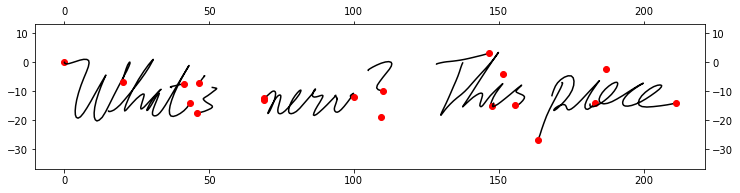

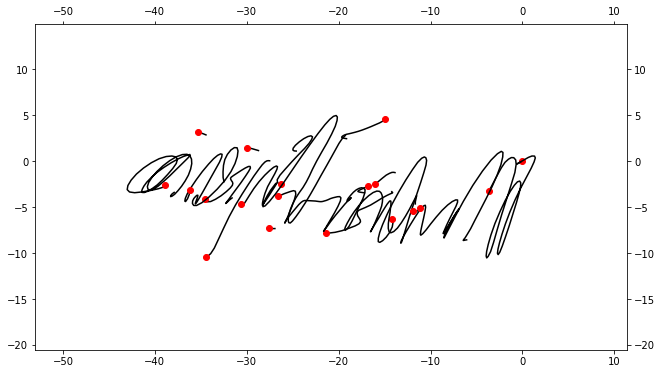

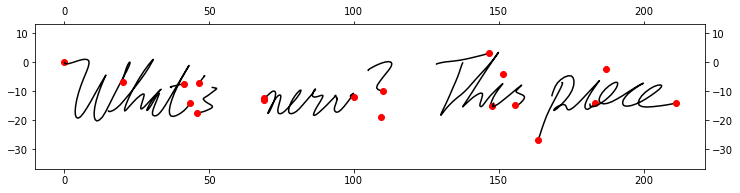

What 's new? This piece


In [6]:
draw(strokes_og[0])
draw(strokes[0])
draw(res2[0])
print(drawing.decode_ascii(strings[0]))

In [7]:
import torch 
from torch import tensor
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [8]:
class HandwritingDataset(Dataset):
    def __init__(self, strokes, stroke_lengths):
        self.strokes = strokes
        self.stroke_lengths = stroke_lengths
        self.mask = self.getMask()
        
    def __len__(self):
        return self.strokes.shape[0]
    
    def __getitem__(self, idx):
        return self.strokes[idx], self.stroke_lengths[idx], self.mask[idx]
    
    def getMask(self):
        mask = np.ones((self.strokes.shape[0], self.strokes.shape[1]))
        for i in range(self.strokes.shape[0]):
            mask[i][self.stroke_lengths[i]:] = 0
        return mask
    
train_dataset = HandwritingDataset(strokes[:10000], stroke_lens[:10000])
test_dataset = HandwritingDataset(strokes[10000:], stroke_lens[10000:])


In [11]:
class HandWritingPredictionWithLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_mixtures):
        super(HandWritingPredictionWithLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_mixtures = num_mixtures
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size+input_size, hidden_size, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_size+input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(3*hidden_size, 6*num_mixtures+1)
        
    def forward(self, inputs, lengths, h0, c0):
        packed_x = pack_padded_sequence(
            inputs,
            lengths.cpu().numpy(),
            batch_first=True)
        packed_out1, _ = self.lstm1(packed_x, (h0, c0))
        out1, _ = pad_packed_sequence(packed_out1, batch_first=True)
        inputs = inputs[:, :out1.shape[1], :]
        packed_inp2 = pack_padded_sequence(
            torch.cat((inputs, out1), -1),
            lengths.cpu().numpy(),
            batch_first=True)
        packed_out2, _ = self.lstm2(packed_inp2, (h0, c0))
        out2, _ = pad_packed_sequence(packed_out2, batch_first=True)

        packed_inp3 = pack_padded_sequence(
            torch.cat((inputs, out2), -1),
            lengths.cpu().numpy(),
            batch_first=True)
        packed_out3, _ = self.lstm3(packed_inp3, (h0, c0))
        out3, _ = pad_packed_sequence(packed_out3, batch_first=True)

        input4 = torch.cat((out1, out2, out3), -1)
        out4 = self.linear(input4)
        return out4, (out1, out2, out3)

input_size = 3
hidden_size = 500
batch_size = 128
n_mixtures = 20
m = HandWritingPredictionWithLSTM(input_size, hidden_size, n_mixtures).to(device)

# def negative_log_likelihood(batch_params, stroke_lengths, batch_targets, batch_mask):  
#     batch_size = batch_params.shape[0]

#     es = 1/(1 + torch.exp(batch_params[:,:,-1]))
#     pis = nn.Softmax(2)(batch_params[:,:,0:n_mixtures])
#     mus = batch_params[:, :, n_mixtures:3*n_mixtures].reshape(batch_size, -1, n_mixtures, 2)
#     sigmas = torch.exp(batch_params[:,:, 3*n_mixtures:5*n_mixtures].reshape(batch_size, -1, n_mixtures, 2))
#     phos = torch.tanh(batch_params[:,:, 5*n_mixtures:6*n_mixtures].reshape(batch_size, -1, n_mixtures, 1))

#     covs = torch.zeros(batch_params.shape[0],
#                        batch_params.shape[1],
#                        n_mixtures, 2, 2, device=device)
#     covs[:,:,:,0,0] = sigmas[:,:,:,0] ** 2
#     covs[:,:,:,0,1] = sigmas[:,:,:,0] * sigmas[:,:,:,1] * phos[:,:,:,0]
#     covs[:,:,:,1,0] = covs[:,:,:,0,1]
#     covs[:,:,:,1,1] = sigmas[:,:,:,1] ** 2

#     distributions = torch.distributions.MultivariateNormal(mus, covs)

#     target_coords = batch_targets[:,:,0:2].unsqueeze(2).repeat_interleave(
#         torch.tensor([n_mixtures], device=device), dim=2)
#     stroke_lift = batch_targets[:,:,-1]

#     probs = torch.exp(distributions.log_prob(target_coords))
#     loss_per_coord = - torch.logsumexp(torch.log(pis) + probs, dim=2)  - torch.log(es)*stroke_lift - torch.log(1 - es)*(1-stroke_lift)
#     batch_loss = (loss_per_coord * batch_mask).sum()
#     return batch_loss/batch_size

def negative_log_likelihood(batch_params, stroke_lengths, batch_targets, batch_mask):  
    batch_loss = 0
    for i in range(len(stroke_lengths)):
        stroke_length = stroke_lengths[i]
        params = batch_params[i][:stroke_length-1]
        targets = batch_targets[i][1:stroke_length]
        
        es = 1/(1 + torch.exp(params[:,-1]))
        pis = nn.Softmax(1)(params[:,0:n_mixtures])
        mus = params[:, n_mixtures:3*n_mixtures].reshape(-1, n_mixtures, 2)
        sigmas = torch.exp(params[:, 3*n_mixtures:5*n_mixtures].reshape(-1, n_mixtures, 2))
        phos = torch.tanh(params[:, 5*n_mixtures:6*n_mixtures].reshape(-1, n_mixtures, 1))

        covs = torch.zeros(stroke_length-1, n_mixtures, 2, 2, device=device)
        tol = torch.tensor(0.000000001, device=device)
        covs[:,:,0,0] = sigmas[:,:,0] ** 2
        covs[:,:,0,1] = sigmas[:,:,0] * sigmas[:,:,1] * phos[:,:,0]
        covs[:,:,1,0] = covs[:,:,0,1]
        covs[:,:,1,1] = sigmas[:,:,1] ** 2


        distributions = torch.distributions.MultivariateNormal(mus, covs)

        target_coords = targets[:,0:2].unsqueeze(1).repeat_interleave(
            torch.tensor([n_mixtures], device=device), dim=1)
        stroke_lift = targets[:,-1]

        probs = torch.exp(distributions.log_prob(target_coords))
        #probs = torch.where(probs > 10, torch.zeros_like(probs) + 10, probs)
        probs = torch.where(probs < 0.000000001, torch.zeros_like(probs) + 0.000000001, probs)
    #     print(torch.log((pis*probs).sum(dim=1)).sum())
    #     print((torch.log(es)*stroke_lift).sum())
    #     print((torch.log(1 - es)*(1-stroke_lift)).sum())

        batch_loss += - (torch.log((pis*probs).sum(dim=1))).sum() - (torch.log(es)*stroke_lift).sum() - (torch.log(1 - es)*(1-stroke_lift)).sum()
    #print(batch_loss/len(stroke_lengths))
    return batch_loss/len(stroke_lengths)


def train(model, input_strokes, stroke_lengths, input_mask, optimizer, h0, c0):
    optimizer.zero_grad()
    
    # prepare for packing
    stroke_lengths_sorted, perm_idx = stroke_lengths.sort(0, descending=True)
    strokes_sorted_by_length = input_strokes[perm_idx]
    input_mask_sorted_by_length = input_mask[perm_idx]

    outputs, _ = model(strokes_sorted_by_length, stroke_lengths_sorted - 1 , h0, c0)

    loss = negative_log_likelihood(
        outputs,
        stroke_lengths_sorted - 1, # We only have T-1 LSTM cells so we need to measure loss on only T-1 units
        strokes_sorted_by_length[:, 1:outputs.shape[1]+1], # We want to offset by 1 as the targets are the predictions for the next data point
        input_mask_sorted_by_length[:, 1:outputs.shape[1]+1]
    )
    loss.backward()
    # Gradient clipping
    # torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
    # torch.clamp_(model.parameters(), 10)
    
    optimizer.step()
    return loss.item()

def sample_drawing():
    timestamps = 1200

    with torch.no_grad():
        h1n=torch.zeros(1, 1, hidden_size, device=device)
        c1n=torch.zeros(1, 1, hidden_size, device=device)
        h2n=torch.zeros(1, 1, hidden_size, device=device)
        c2n=torch.zeros(1, 1, hidden_size, device=device)
        h3n=torch.zeros(1, 1, hidden_size, device=device)
        c3n=torch.zeros(1, 1, hidden_size, device=device)
        predictions = torch.zeros(timestamps, 3, device=device)
        predictions[0, 2] = 1
        for i in range(timestamps-1):
            x = predictions[i].unsqueeze(0).unsqueeze(0)
            
            out1, (h1n, c1n) = m.lstm1(x, (h1n, c1n))
            out2, (h2n, c2n) = m.lstm2(torch.cat((x, out1), -1), (h2n, c2n))
            out3, (h3n, c3n) = m.lstm3(torch.cat((x, out2), -1), (h3n, c3n))
            input4 = torch.cat((out1, out2, out3), -1)
            params = m.linear(input4)[0]

            es = 1/(1 + torch.exp(params[:,-1]))
            pis = nn.Softmax(1)(params[:,0:n_mixtures])
            mus = params[:, n_mixtures:3*n_mixtures].reshape(-1, n_mixtures, 2)
            sigmas = torch.exp(params[:, 3*n_mixtures:5*n_mixtures].reshape(-1, n_mixtures, 2))
            phos = torch.tanh(params[:, 5*n_mixtures:6*n_mixtures].reshape(-1, n_mixtures, 1))

            covs = torch.zeros(n_mixtures, 2, 2, device=device)
            tol = torch.tensor(0.000000001, device=device)
            covs[:,0,0] = sigmas[:,:,0] ** 2
            covs[:,0,1] = sigmas[:,:,0] * sigmas[:,:,1] * phos[:,:,0]
            covs[:,1,0] = covs[:,0,1]
            covs[:,1,1] = sigmas[:,:,1] ** 2

            sample_index = np.random.choice(
                range(n_mixtures),
                p = pis.squeeze().cpu().numpy())

            pen_off = np.random.binomial(1,es.item())

            sample_point = np.random.multivariate_normal(
                mus.squeeze()[sample_index].cpu().numpy(),
                covs[sample_index].cpu().numpy())

            predictions[i+1, 0] = sample_point[0]
            predictions[i+1, 1] = sample_point[1]
            predictions[i+1, 2] = pen_off
            
        predictions[1:, 0:2] *= torch.tensor(std, device=device)
        predictions[1:, 0:2] += torch.tensor(means, device=device)

    drawing.draw(predictions.cpu(), align_strokes=False, denoise_strokes=False, plot_end_points=False)
    plt.show()


n_iter: 0 of 15600, loss: 40.39174560546875, timeElapsed: 3.1167781352996826


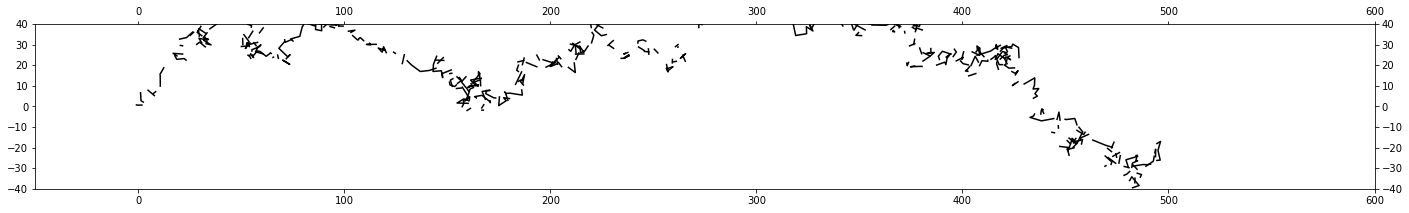

n_iter: 50 of 15600, loss: 1925.8716040039062, timeElapsed: 140.88981866836548
n_iter: 100 of 15600, loss: 1867.3338012695312, timeElapsed: 277.3691747188568
n_iter: 150 of 15600, loss: 1733.0232568359374, timeElapsed: 412.9741132259369
n_iter: 200 of 15600, loss: 1087.397960205078, timeElapsed: 533.9739344120026


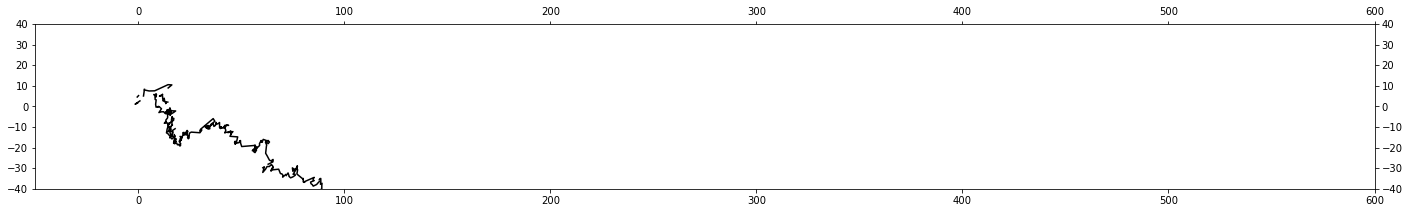

n_iter: 250 of 15600, loss: 880.8577612304688, timeElapsed: 656.6933214664459
n_iter: 300 of 15600, loss: 841.8369580078125, timeElapsed: 777.563636302948
n_iter: 350 of 15600, loss: 825.0148388671874, timeElapsed: 898.9910657405853
n_iter: 400 of 15600, loss: 811.4107727050781, timeElapsed: 1019.8116171360016


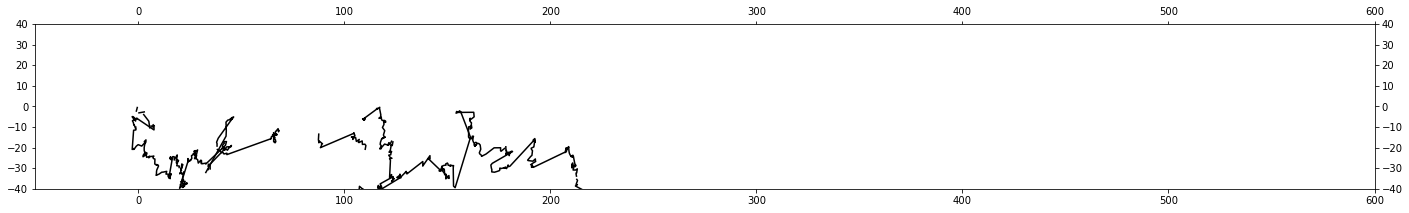

n_iter: 450 of 15600, loss: 801.3201391601563, timeElapsed: 1141.7921895980835
n_iter: 500 of 15600, loss: 787.9569580078125, timeElapsed: 1263.1243588924408
n_iter: 550 of 15600, loss: 772.1550354003906, timeElapsed: 1384.776017665863
n_iter: 600 of 15600, loss: 741.8991064453126, timeElapsed: 1505.6411707401276


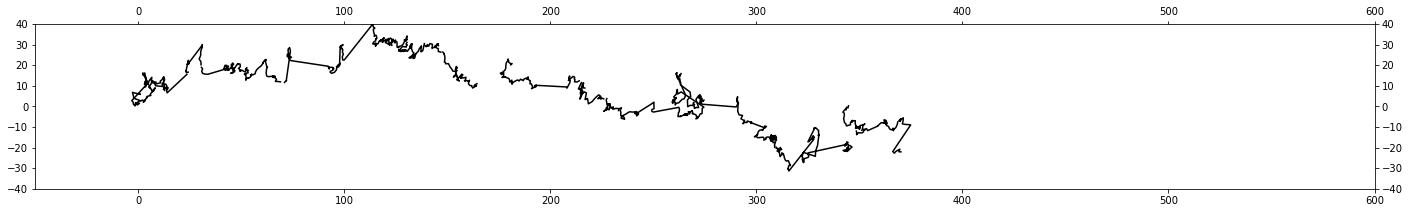

n_iter: 650 of 15600, loss: 688.5081750488281, timeElapsed: 1627.52751994133
n_iter: 700 of 15600, loss: 653.8662658691406, timeElapsed: 1748.720185995102
n_iter: 750 of 15600, loss: 615.4069592285156, timeElapsed: 1869.2650282382965
n_iter: 800 of 15600, loss: 581.7565356445313, timeElapsed: 1990.5099771022797


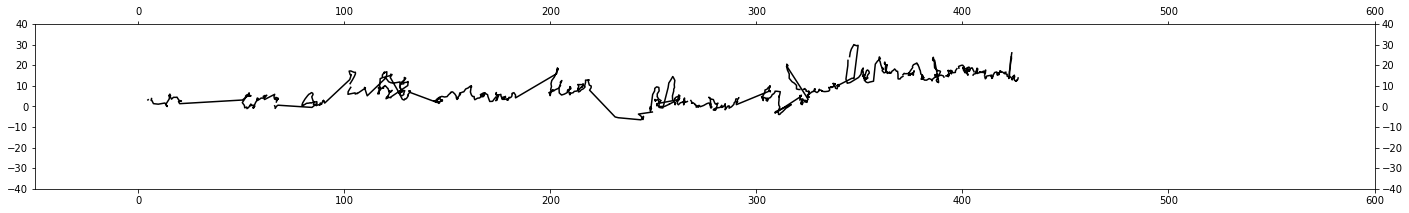

n_iter: 850 of 15600, loss: 562.5378234863281, timeElapsed: 2112.983580350876
n_iter: 900 of 15600, loss: 538.6523645019531, timeElapsed: 2233.5423045158386
n_iter: 950 of 15600, loss: 515.8215008544922, timeElapsed: 2354.3087813854218
n_iter: 1000 of 15600, loss: 497.9177685546875, timeElapsed: 2475.6976583004


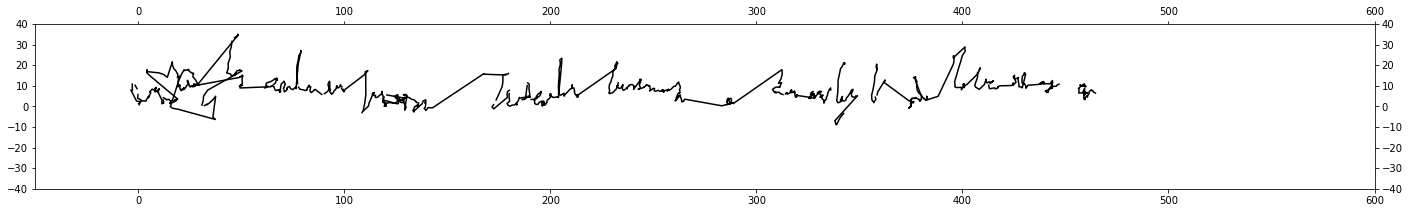

n_iter: 1050 of 15600, loss: 479.9245428466797, timeElapsed: 2598.6661744117737
n_iter: 1100 of 15600, loss: 456.61450744628905, timeElapsed: 2719.2175533771515
n_iter: 1150 of 15600, loss: 438.32164794921874, timeElapsed: 2839.562780380249
n_iter: 1200 of 15600, loss: 418.81255126953124, timeElapsed: 2961.049003601074


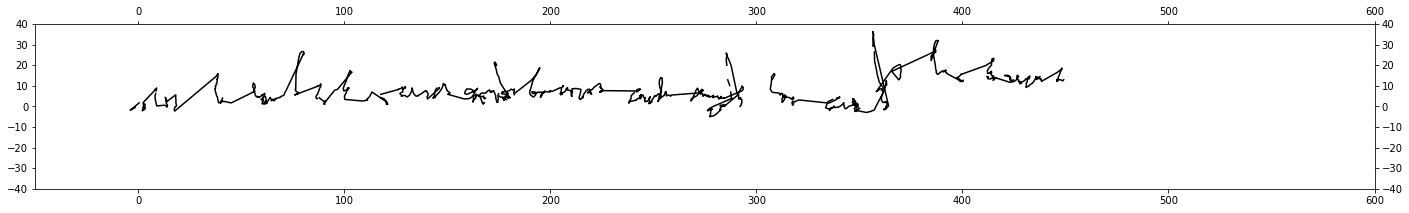

n_iter: 1250 of 15600, loss: 403.5442163085938, timeElapsed: 3083.5645730495453
n_iter: 1300 of 15600, loss: 381.97161193847654, timeElapsed: 3205.0231697559357
n_iter: 1350 of 15600, loss: 365.2477325439453, timeElapsed: 3325.0771794319153
n_iter: 1400 of 15600, loss: 344.637763671875, timeElapsed: 3445.9128818511963


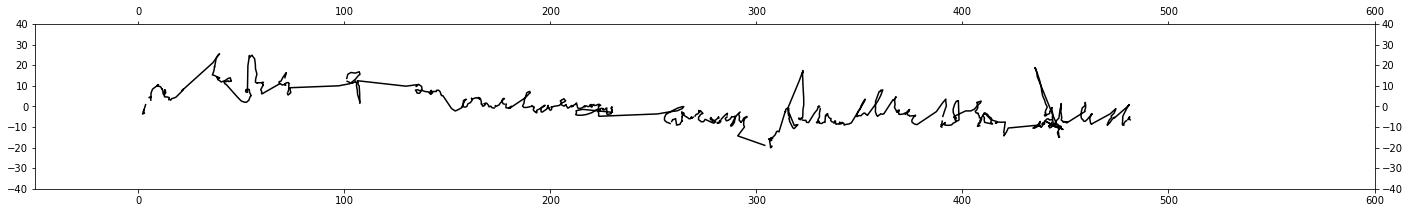

n_iter: 1450 of 15600, loss: 328.87504821777344, timeElapsed: 3567.9308066368103
n_iter: 1500 of 15600, loss: 306.70334716796873, timeElapsed: 3688.3951461315155
n_iter: 1550 of 15600, loss: 285.6596221923828, timeElapsed: 3809.3239715099335
n_iter: 1600 of 15600, loss: 275.2986428833008, timeElapsed: 3930.16397857666


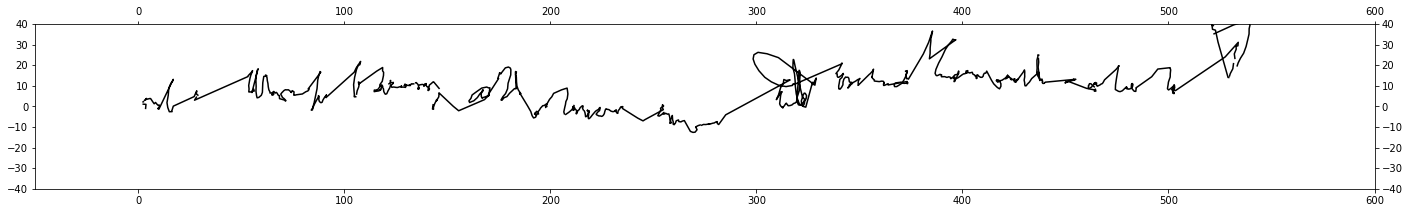

n_iter: 1650 of 15600, loss: 249.4800241088867, timeElapsed: 4052.4591941833496
n_iter: 1700 of 15600, loss: 231.94766479492188, timeElapsed: 4173.225029468536
n_iter: 1750 of 15600, loss: 216.8337893676758, timeElapsed: 4293.729971170425
n_iter: 1800 of 15600, loss: 195.1294332885742, timeElapsed: 4413.978933334351


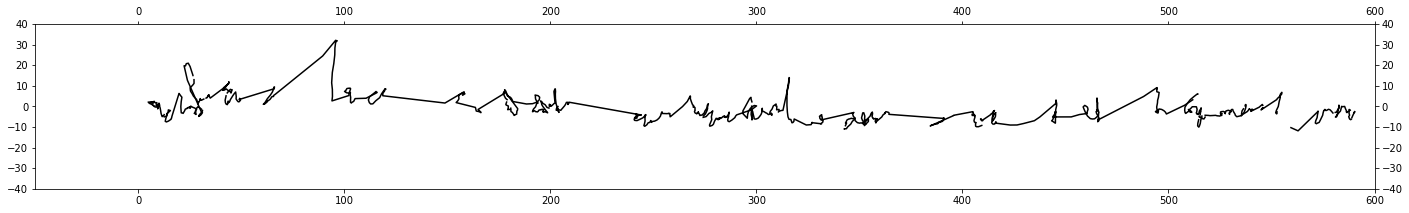

n_iter: 1850 of 15600, loss: 180.00220977783204, timeElapsed: 4535.624182701111
n_iter: 1900 of 15600, loss: 165.97539489746094, timeElapsed: 4656.474694490433
n_iter: 1950 of 15600, loss: 146.88798706054686, timeElapsed: 4777.342931509018
n_iter: 2000 of 15600, loss: 131.81084564208984, timeElapsed: 4897.631866455078


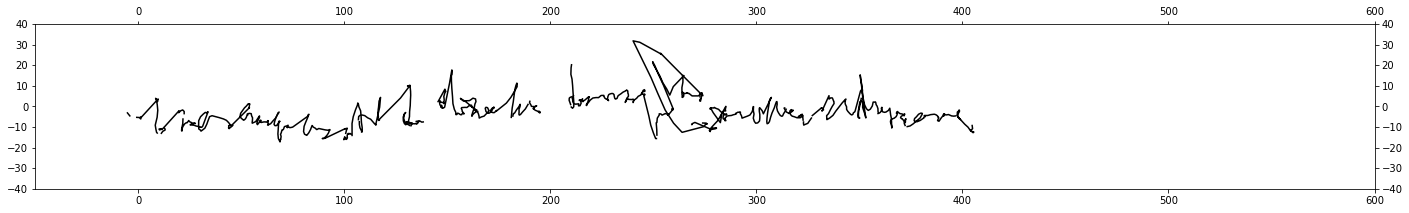

n_iter: 2050 of 15600, loss: 113.76898574829102, timeElapsed: 5019.787691116333
n_iter: 2100 of 15600, loss: 106.03283065795898, timeElapsed: 5140.721702098846
n_iter: 2150 of 15600, loss: 84.37882667541504, timeElapsed: 5261.981017112732
n_iter: 2200 of 15600, loss: 74.30045665740967, timeElapsed: 5382.796397447586


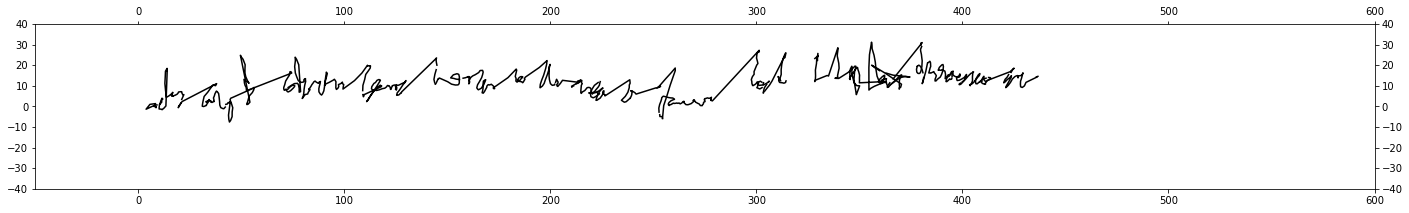

n_iter: 2250 of 15600, loss: 62.76357536315918, timeElapsed: 5505.185135602951
n_iter: 2300 of 15600, loss: 48.19567663192749, timeElapsed: 5629.827029466629
n_iter: 2350 of 15600, loss: 33.84932904958725, timeElapsed: 5755.140830755234
n_iter: 2400 of 15600, loss: 26.86771354585886, timeElapsed: 5881.083003282547


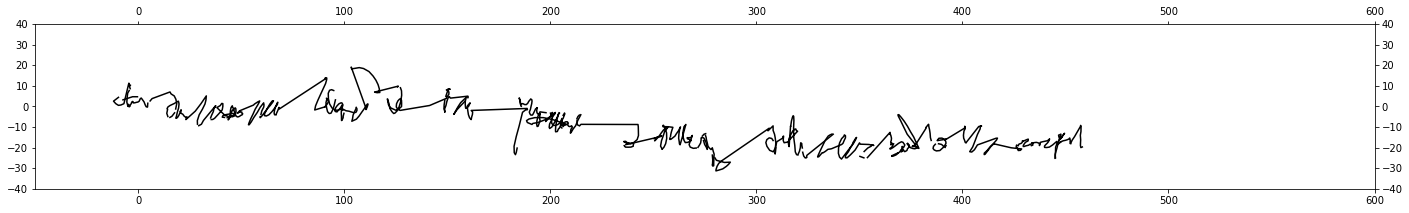

n_iter: 2450 of 15600, loss: 14.601199672222137, timeElapsed: 6008.139867544174
n_iter: 2500 of 15600, loss: -6.342348840236664, timeElapsed: 6133.399898052216
n_iter: 2550 of 15600, loss: -13.866590762138367, timeElapsed: 6258.800256967545
n_iter: 2600 of 15600, loss: -19.148416290283205, timeElapsed: 6384.095730066299


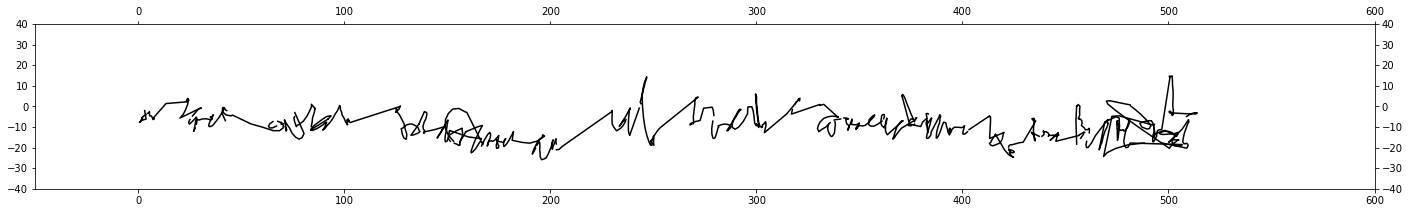

n_iter: 2650 of 15600, loss: -33.82178885132075, timeElapsed: 6511.842643976212
n_iter: 2700 of 15600, loss: -48.878480138778684, timeElapsed: 6636.600559949875
n_iter: 2750 of 15600, loss: -52.349116773605346, timeElapsed: 6761.506085395813
n_iter: 2800 of 15600, loss: -69.6148638534546, timeElapsed: 6886.266741991043


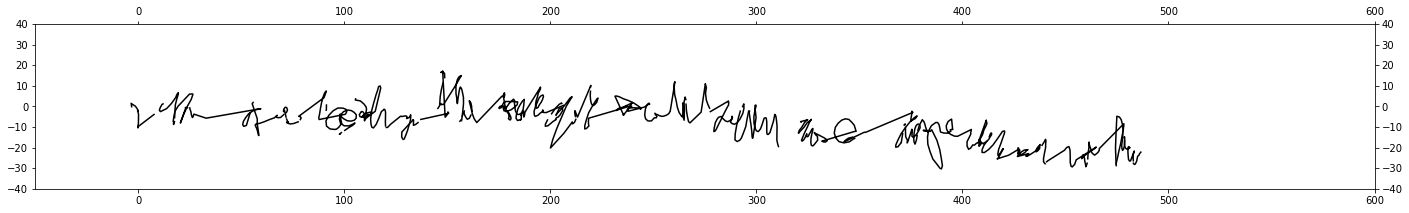

n_iter: 2850 of 15600, loss: -78.27714157104492, timeElapsed: 7013.231329202652
n_iter: 2900 of 15600, loss: -92.64458168029785, timeElapsed: 7138.3258175849915
n_iter: 2950 of 15600, loss: -103.95394744873047, timeElapsed: 7263.765062093735
n_iter: 3000 of 15600, loss: -117.6835287475586, timeElapsed: 7388.072765350342


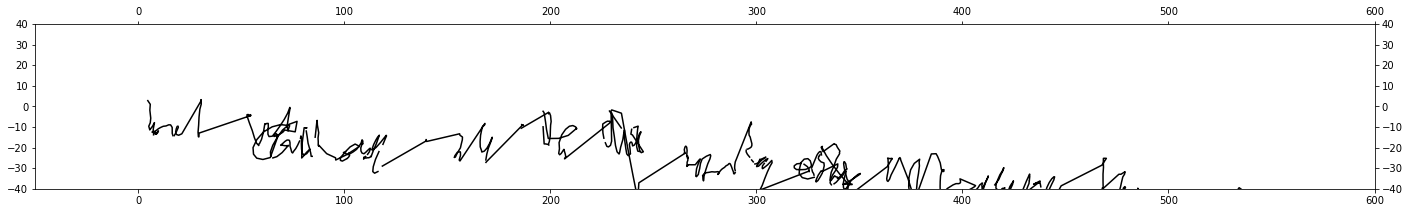

n_iter: 3050 of 15600, loss: -123.77857803344726, timeElapsed: 7514.283587694168
n_iter: 3100 of 15600, loss: -142.38422332763673, timeElapsed: 7639.129878282547
n_iter: 3150 of 15600, loss: -158.5837794494629, timeElapsed: 7764.282596111298
n_iter: 3200 of 15600, loss: -163.32947875976564, timeElapsed: 7888.350955963135


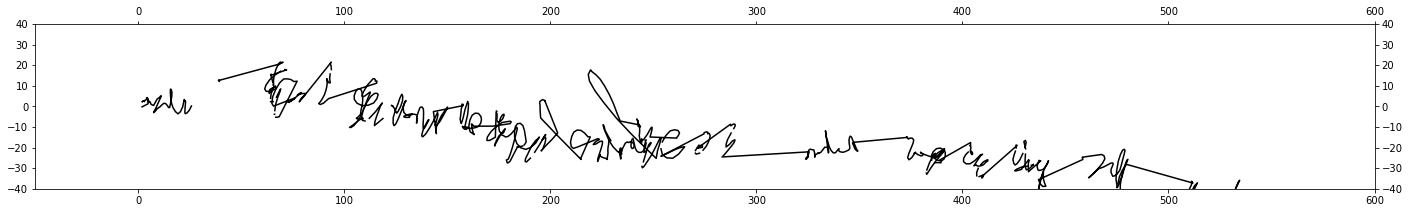

n_iter: 3250 of 15600, loss: -176.05572341918946, timeElapsed: 8014.940329313278
n_iter: 3300 of 15600, loss: -192.07236419677736, timeElapsed: 8140.02331829071
n_iter: 3350 of 15600, loss: -202.67235107421874, timeElapsed: 8265.585465192795
n_iter: 3400 of 15600, loss: -217.66387329101562, timeElapsed: 8389.80550956726


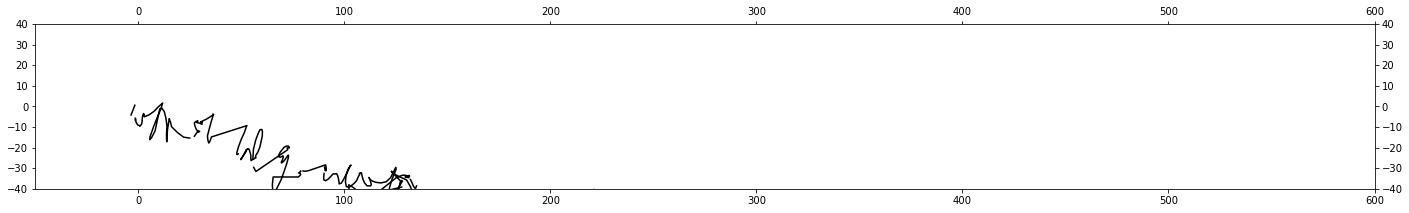

n_iter: 3450 of 15600, loss: -221.64976364135742, timeElapsed: 8516.638686656952
n_iter: 3500 of 15600, loss: -231.3787646484375, timeElapsed: 8641.33285188675
n_iter: 3550 of 15600, loss: -243.39948333740233, timeElapsed: 8766.96468448639
n_iter: 3600 of 15600, loss: -263.75502136230466, timeElapsed: 8891.599340200424


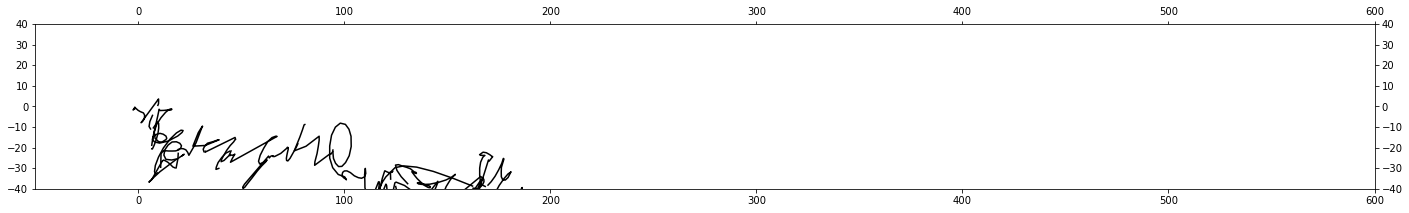

n_iter: 3650 of 15600, loss: -262.24497192382813, timeElapsed: 9018.251708745956
n_iter: 3700 of 15600, loss: -274.7396536254883, timeElapsed: 9143.013467550278
n_iter: 3750 of 15600, loss: -287.15299255371093, timeElapsed: 9268.542749404907
n_iter: 3800 of 15600, loss: -294.2186389160156, timeElapsed: 9393.799700975418


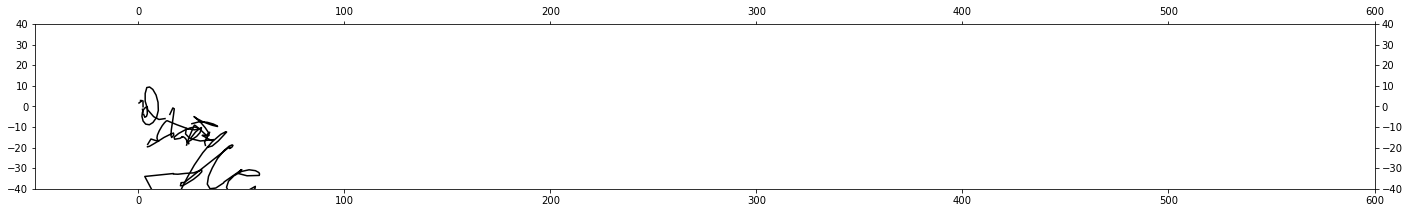

n_iter: 3850 of 15600, loss: -303.8705551147461, timeElapsed: 9521.074604511261
n_iter: 3900 of 15600, loss: -316.08772247314454, timeElapsed: 9646.739870071411
n_iter: 3950 of 15600, loss: -326.3550180053711, timeElapsed: 9772.796335697174
n_iter: 4000 of 15600, loss: -331.2560516357422, timeElapsed: 9898.146333932877


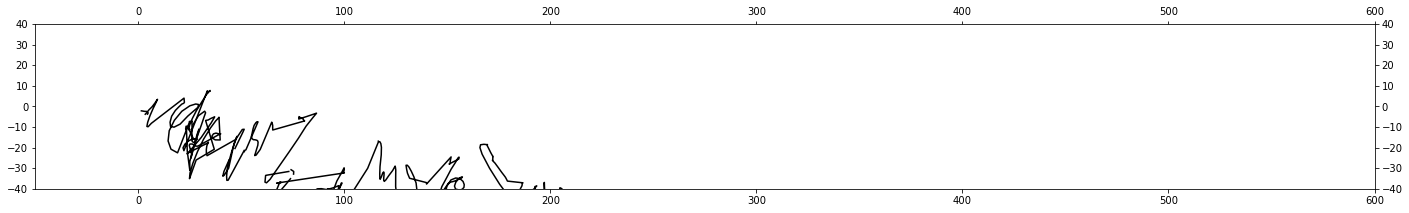

n_iter: 4050 of 15600, loss: -340.1495074462891, timeElapsed: 10024.891098737717
n_iter: 4100 of 15600, loss: -352.8921295166016, timeElapsed: 10148.925886392593
n_iter: 4150 of 15600, loss: -364.56188537597654, timeElapsed: 10274.786170721054
n_iter: 4200 of 15600, loss: -368.77281188964844, timeElapsed: 10399.270972967148


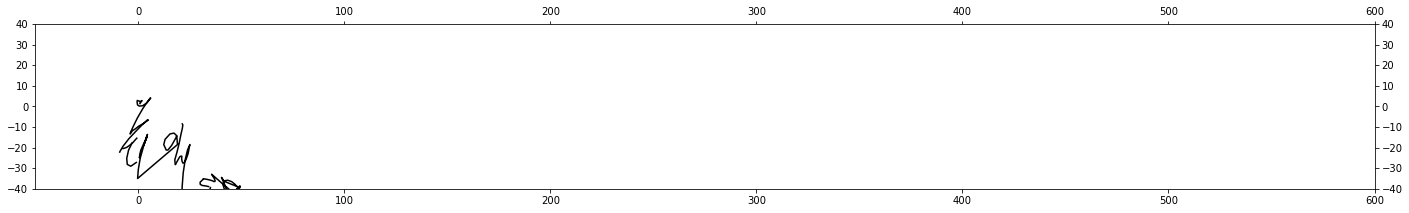

n_iter: 4250 of 15600, loss: -385.8716009521484, timeElapsed: 10525.95993924141
n_iter: 4300 of 15600, loss: -386.30647705078127, timeElapsed: 10651.90415430069
n_iter: 4350 of 15600, loss: -403.19882629394533, timeElapsed: 10777.695203781128
n_iter: 4400 of 15600, loss: -406.56874877929687, timeElapsed: 10903.990242004395


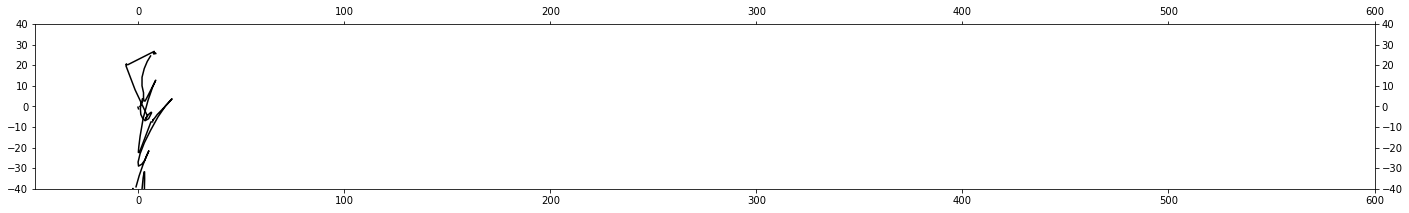

n_iter: 4450 of 15600, loss: -420.1426684570313, timeElapsed: 11031.180730104446
n_iter: 4500 of 15600, loss: -422.3649792480469, timeElapsed: 11156.50566148758
n_iter: 4550 of 15600, loss: -436.8262628173828, timeElapsed: 11282.446638584137
n_iter: 4600 of 15600, loss: -447.9431628417969, timeElapsed: 11407.715243816376


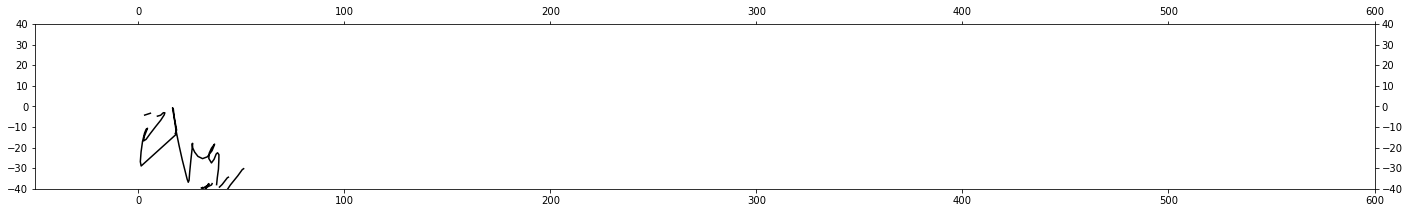

n_iter: 4650 of 15600, loss: -450.36579345703126, timeElapsed: 11534.46189236641
n_iter: 4700 of 15600, loss: -459.45665100097654, timeElapsed: 11659.623457193375
n_iter: 4750 of 15600, loss: -463.4864471435547, timeElapsed: 11785.111566066742
n_iter: 4800 of 15600, loss: -471.7974237060547, timeElapsed: 11910.036380767822


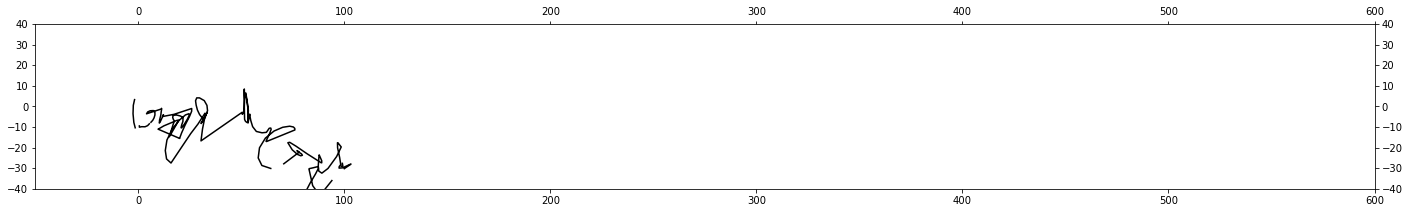

n_iter: 4850 of 15600, loss: -480.91046752929685, timeElapsed: 12037.889565706253
n_iter: 4900 of 15600, loss: -479.59242858886716, timeElapsed: 12163.21794629097
n_iter: 4950 of 15600, loss: -497.0267980957031, timeElapsed: 12288.467299222946
n_iter: 5000 of 15600, loss: -493.67260375976565, timeElapsed: 12414.133293151855


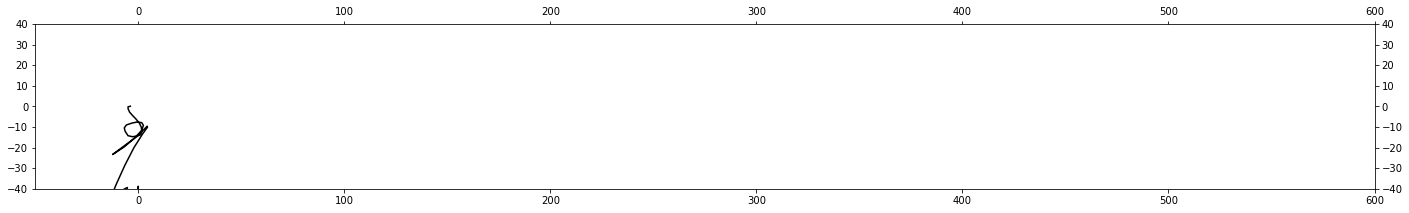

n_iter: 5050 of 15600, loss: -500.3185479736328, timeElapsed: 12541.239839076996
n_iter: 5100 of 15600, loss: -511.76831970214846, timeElapsed: 12665.895640850067
n_iter: 5150 of 15600, loss: -517.9730804443359, timeElapsed: 12791.141330718994
n_iter: 5200 of 15600, loss: -518.3543182373047, timeElapsed: 12916.078450679779


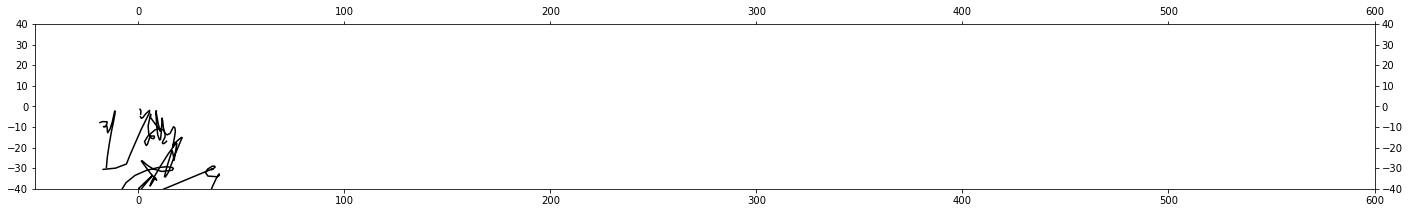

n_iter: 5250 of 15600, loss: -526.5927923583985, timeElapsed: 13043.236628770828
n_iter: 5300 of 15600, loss: -525.028892211914, timeElapsed: 13167.873886108398
n_iter: 5350 of 15600, loss: -531.1234075927734, timeElapsed: 13292.823289632797
n_iter: 5400 of 15600, loss: -538.4744549560547, timeElapsed: 13417.772180080414


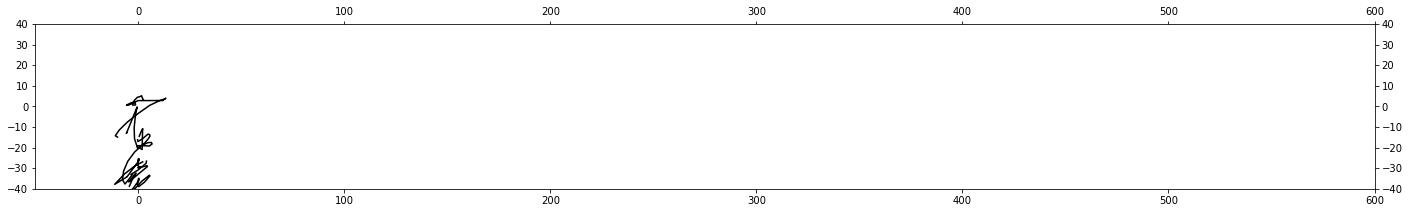

n_iter: 5450 of 15600, loss: -541.0043920898438, timeElapsed: 13544.117068767548
n_iter: 5500 of 15600, loss: -540.430219116211, timeElapsed: 13669.467700958252
n_iter: 5550 of 15600, loss: -556.4744787597656, timeElapsed: 13795.225484132767
n_iter: 5600 of 15600, loss: -554.0678558349609, timeElapsed: 13920.389003038406


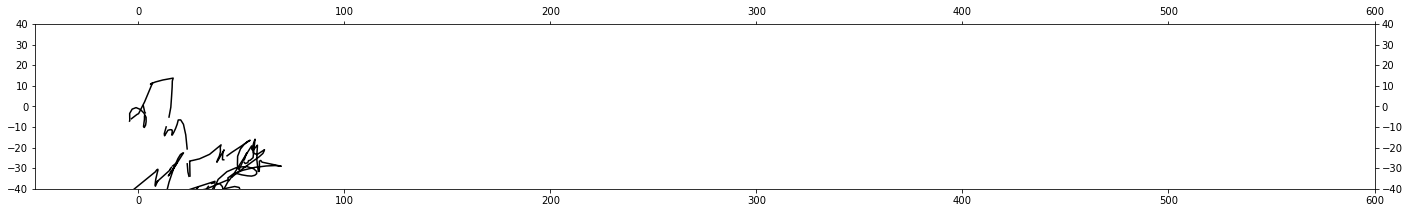

n_iter: 5650 of 15600, loss: -547.0939727783203, timeElapsed: 14045.335801124573
n_iter: 5700 of 15600, loss: -561.7374816894531, timeElapsed: 14171.110414266586
n_iter: 5750 of 15600, loss: -571.3900512695312, timeElapsed: 14296.80042219162
n_iter: 5800 of 15600, loss: -564.4587072753907, timeElapsed: 14421.715735197067


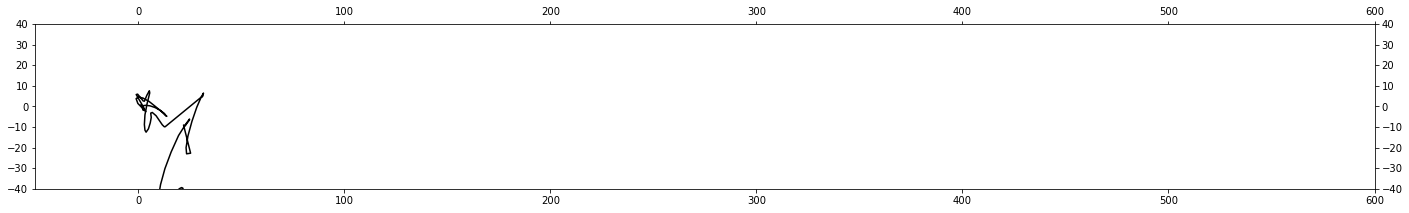

n_iter: 5850 of 15600, loss: -570.3760064697266, timeElapsed: 14547.688604593277
n_iter: 5900 of 15600, loss: -572.5192767333984, timeElapsed: 14674.174086332321
n_iter: 5950 of 15600, loss: -580.9549768066406, timeElapsed: 14798.800950527191
n_iter: 6000 of 15600, loss: -576.1778979492187, timeElapsed: 14923.71161699295


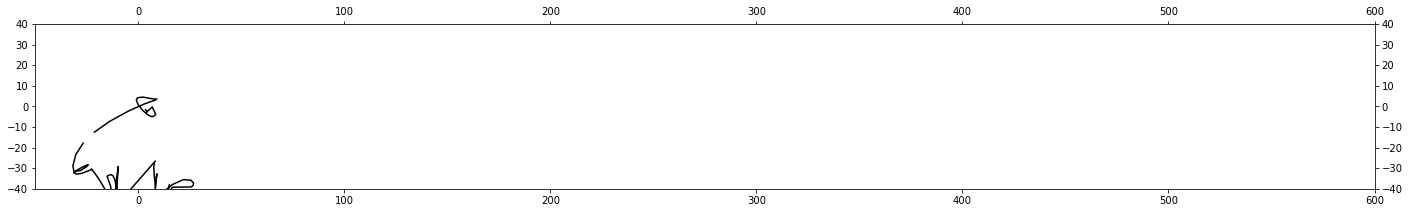

n_iter: 6050 of 15600, loss: -582.1541662597656, timeElapsed: 15048.99184513092
n_iter: 6100 of 15600, loss: -587.5489050292969, timeElapsed: 15174.062963724136
n_iter: 6150 of 15600, loss: -589.0582855224609, timeElapsed: 15299.297135353088
n_iter: 6200 of 15600, loss: -592.5588012695313, timeElapsed: 15425.011249303818


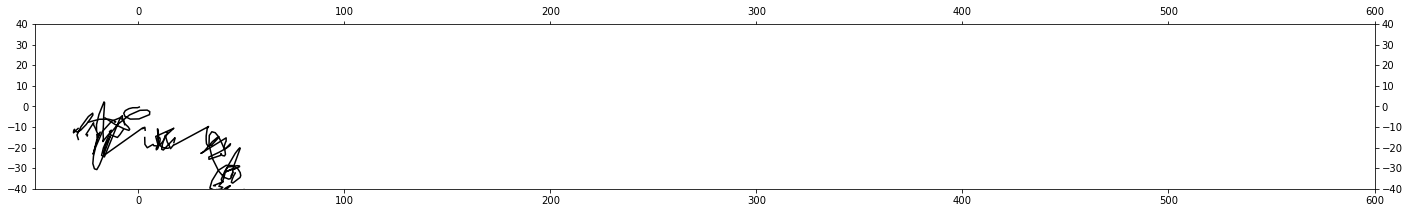

n_iter: 6250 of 15600, loss: -589.333091430664, timeElapsed: 15551.707128047943
n_iter: 6300 of 15600, loss: -597.3108129882812, timeElapsed: 15676.892058849335
n_iter: 6350 of 15600, loss: -599.2093640136719, timeElapsed: 15802.041110754013
n_iter: 6400 of 15600, loss: -597.3017010498047, timeElapsed: 15927.031308174133


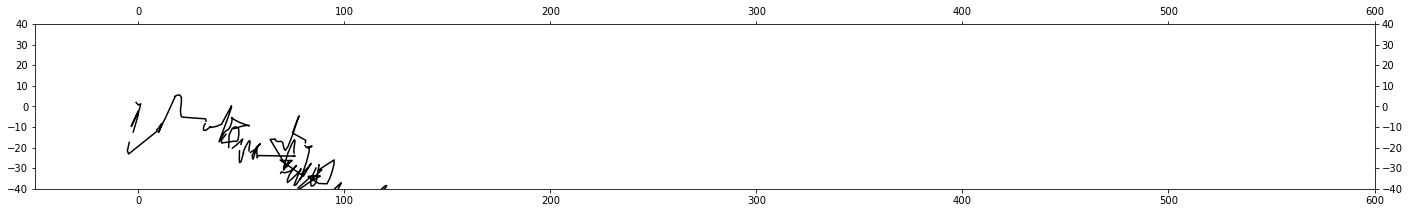

n_iter: 6450 of 15600, loss: -604.8677813720703, timeElapsed: 16053.607766866684
n_iter: 6500 of 15600, loss: -605.1780786132813, timeElapsed: 16178.532113552094
n_iter: 6550 of 15600, loss: -609.6228466796875, timeElapsed: 16303.456238746643
n_iter: 6600 of 15600, loss: -616.3628308105468, timeElapsed: 16428.779557466507


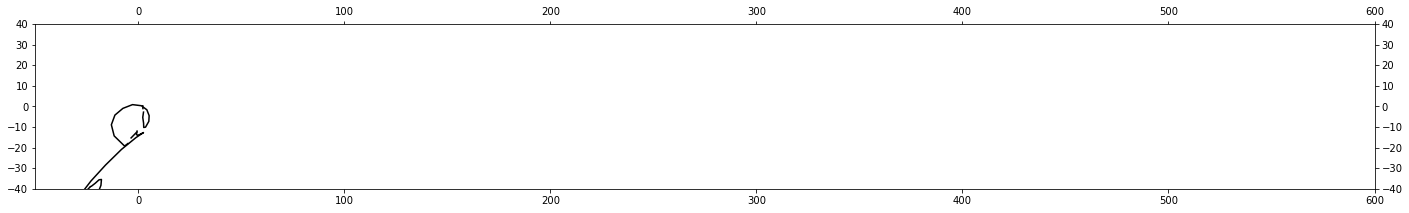

n_iter: 6650 of 15600, loss: -601.3992895507813, timeElapsed: 16555.510320425034
n_iter: 6700 of 15600, loss: -621.6554418945312, timeElapsed: 16681.941385507584
n_iter: 6750 of 15600, loss: -614.83419921875, timeElapsed: 16806.962191820145
n_iter: 6800 of 15600, loss: -619.4677136230468, timeElapsed: 16931.878754377365


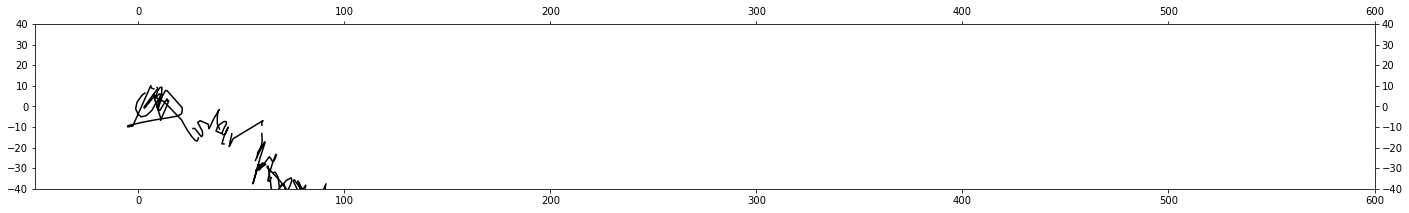

n_iter: 6850 of 15600, loss: -612.2916870117188, timeElapsed: 17058.277902126312
n_iter: 6900 of 15600, loss: -625.5109594726563, timeElapsed: 17183.672646284103
n_iter: 6950 of 15600, loss: -622.8068103027343, timeElapsed: 17308.316010713577
n_iter: 7000 of 15600, loss: -630.7156286621093, timeElapsed: 17433.32718706131


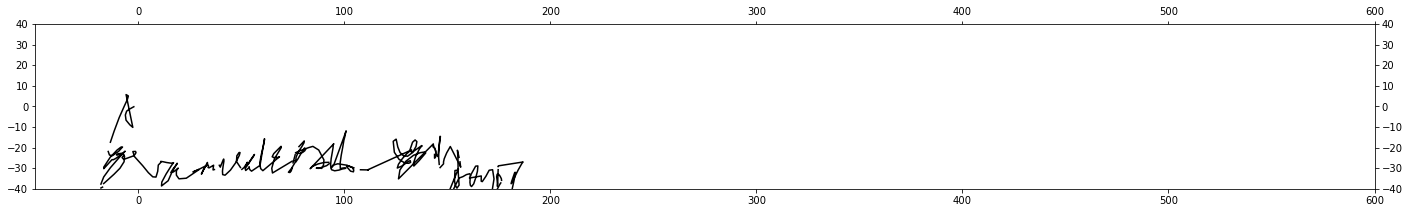

n_iter: 7050 of 15600, loss: -632.3558178710938, timeElapsed: 17560.42330980301
n_iter: 7100 of 15600, loss: -627.6715588378906, timeElapsed: 17686.11135172844
n_iter: 7150 of 15600, loss: -628.3142468261718, timeElapsed: 17811.73640561104
n_iter: 7200 of 15600, loss: -642.0029870605468, timeElapsed: 17937.60561156273


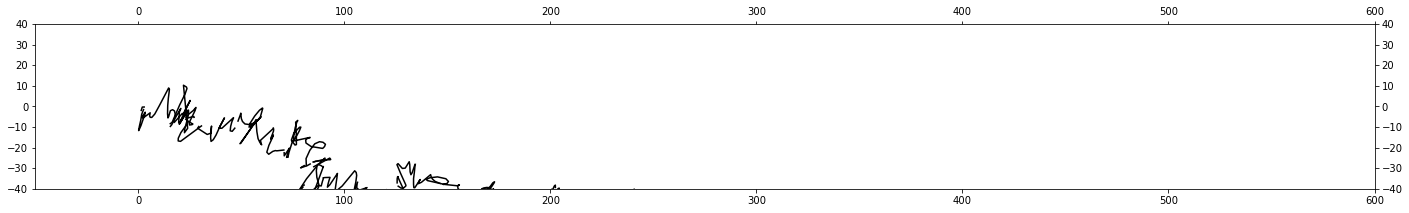

n_iter: 7250 of 15600, loss: -633.3440026855469, timeElapsed: 18064.274428606033
n_iter: 7300 of 15600, loss: -638.5470922851563, timeElapsed: 18189.781470537186
n_iter: 7350 of 15600, loss: -636.393984375, timeElapsed: 18314.813970327377
n_iter: 7400 of 15600, loss: -646.7590222167969, timeElapsed: 18440.631550073624


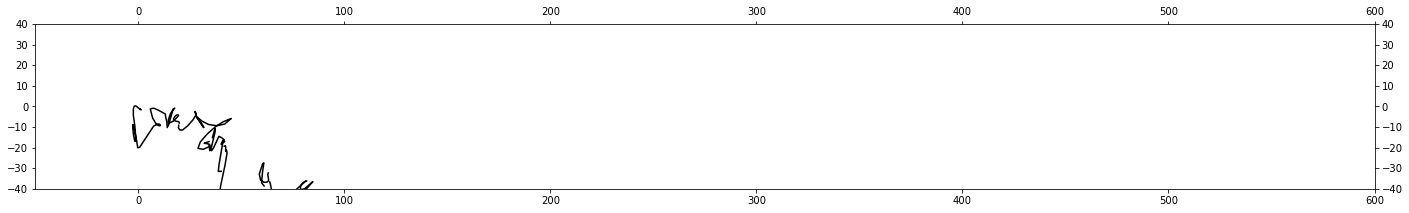

n_iter: 7450 of 15600, loss: -637.232431640625, timeElapsed: 18567.233642578125
n_iter: 7500 of 15600, loss: -651.145673828125, timeElapsed: 18692.052344322205
n_iter: 7550 of 15600, loss: -644.9803674316406, timeElapsed: 18817.385886907578
n_iter: 7600 of 15600, loss: -639.7179992675781, timeElapsed: 18943.28064584732


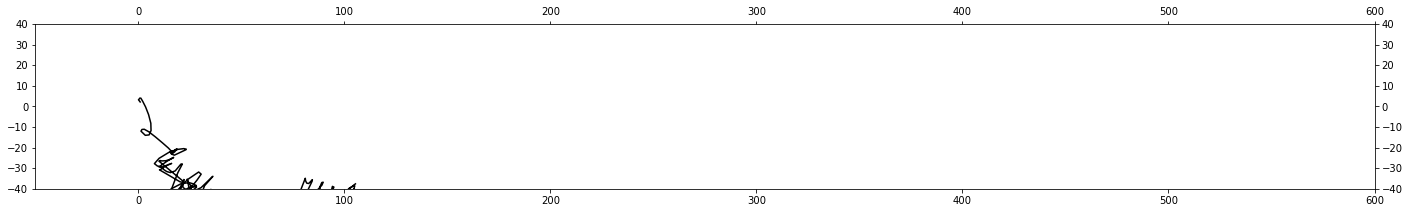

n_iter: 7650 of 15600, loss: -653.6518872070312, timeElapsed: 19070.30227780342
n_iter: 7700 of 15600, loss: -654.0884985351563, timeElapsed: 19195.998824834824
n_iter: 7750 of 15600, loss: -657.4225842285156, timeElapsed: 19321.908906936646
n_iter: 7800 of 15600, loss: -650.7975170898437, timeElapsed: 19446.20728993416


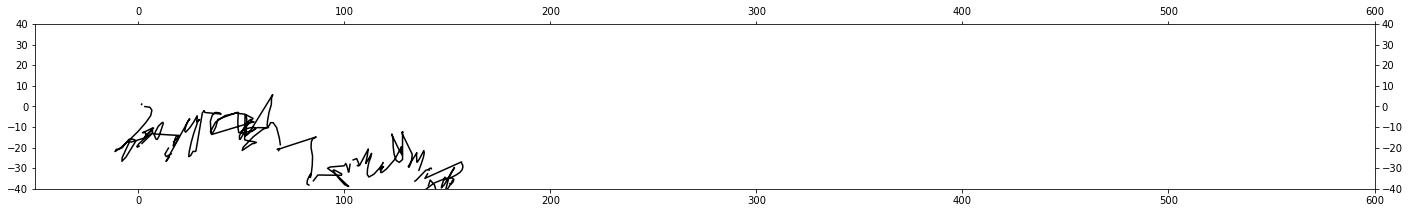

n_iter: 7850 of 15600, loss: -653.0680249023437, timeElapsed: 19573.817177534103
n_iter: 7900 of 15600, loss: -662.8067333984375, timeElapsed: 19698.907983779907
n_iter: 7950 of 15600, loss: -659.3049914550782, timeElapsed: 19824.02360200882
n_iter: 8000 of 15600, loss: -659.9006945800782, timeElapsed: 19949.871976614


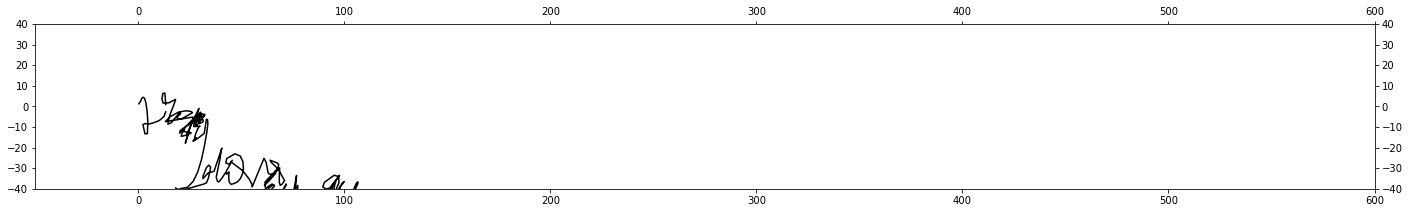

n_iter: 8050 of 15600, loss: -663.6895886230469, timeElapsed: 20076.348405599594
n_iter: 8100 of 15600, loss: -666.4670471191406, timeElapsed: 20201.306390285492
n_iter: 8150 of 15600, loss: -669.8864599609375, timeElapsed: 20326.116626739502
n_iter: 8200 of 15600, loss: -658.1633850097656, timeElapsed: 20451.678020715714


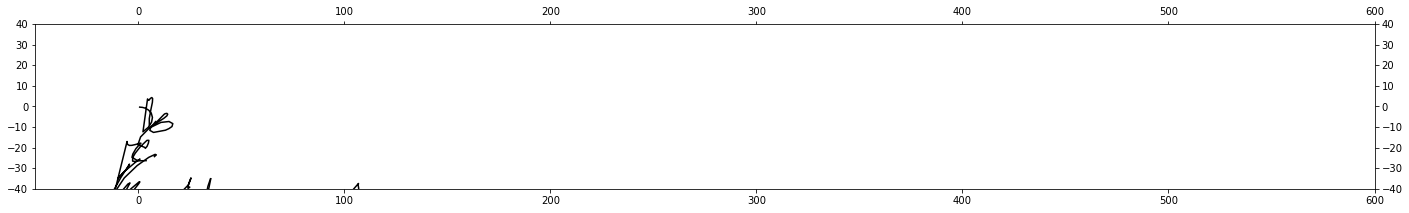

n_iter: 8250 of 15600, loss: -676.3138854980468, timeElapsed: 20578.85906457901
n_iter: 8300 of 15600, loss: -662.5013024902344, timeElapsed: 20704.007304906845
n_iter: 8350 of 15600, loss: -676.4166540527344, timeElapsed: 20829.036393404007
n_iter: 8400 of 15600, loss: -667.8228405761719, timeElapsed: 20953.75478196144


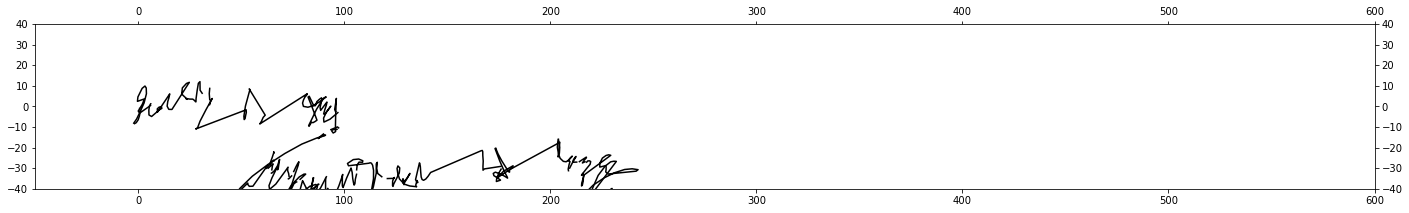

n_iter: 8450 of 15600, loss: -679.1673205566407, timeElapsed: 21081.25956439972
n_iter: 8500 of 15600, loss: -677.7739208984375, timeElapsed: 21207.36764574051
n_iter: 8550 of 15600, loss: -679.5354614257812, timeElapsed: 21333.07998251915
n_iter: 8600 of 15600, loss: -676.2990454101563, timeElapsed: 21458.397705078125


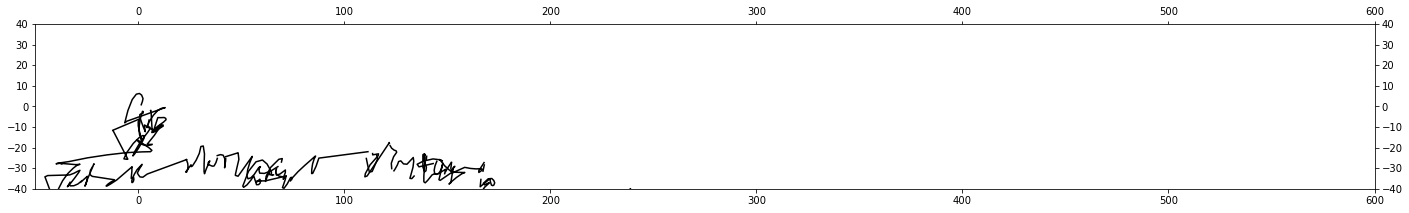

n_iter: 8650 of 15600, loss: -679.9314086914062, timeElapsed: 21584.62017607689
n_iter: 8700 of 15600, loss: -684.5041540527344, timeElapsed: 21710.223061800003
n_iter: 8750 of 15600, loss: -680.6908825683594, timeElapsed: 21835.498612880707
n_iter: 8800 of 15600, loss: -683.6266772460938, timeElapsed: 21960.82054901123


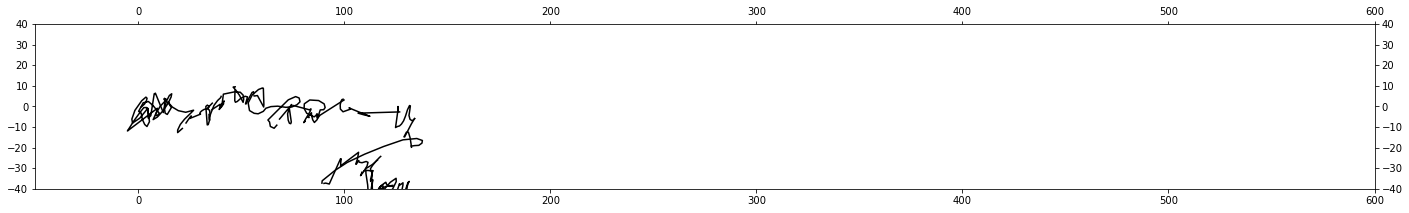

n_iter: 8850 of 15600, loss: -688.6838513183594, timeElapsed: 22087.720771551132
n_iter: 8900 of 15600, loss: -687.6949145507813, timeElapsed: 22213.585706472397
n_iter: 8950 of 15600, loss: -684.9383227539063, timeElapsed: 22339.773365974426
n_iter: 9000 of 15600, loss: -692.2151513671874, timeElapsed: 22465.070296049118


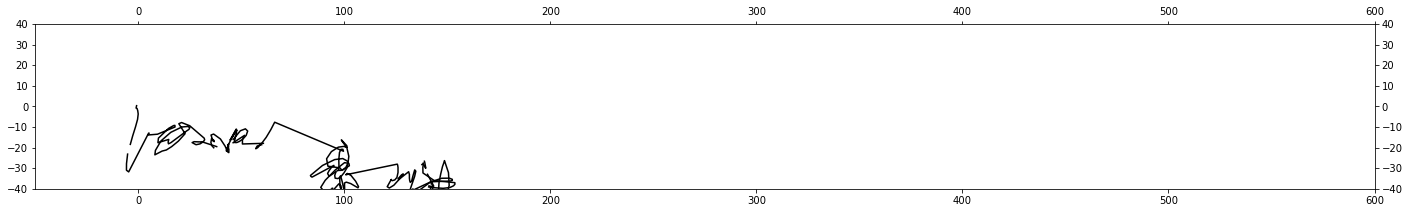

n_iter: 9050 of 15600, loss: -690.341201171875, timeElapsed: 22591.690815925598
n_iter: 9100 of 15600, loss: -694.2156970214844, timeElapsed: 22718.12458872795
n_iter: 9150 of 15600, loss: -695.6233728027344, timeElapsed: 22843.413146018982
n_iter: 9200 of 15600, loss: -690.1442309570313, timeElapsed: 22968.651534080505


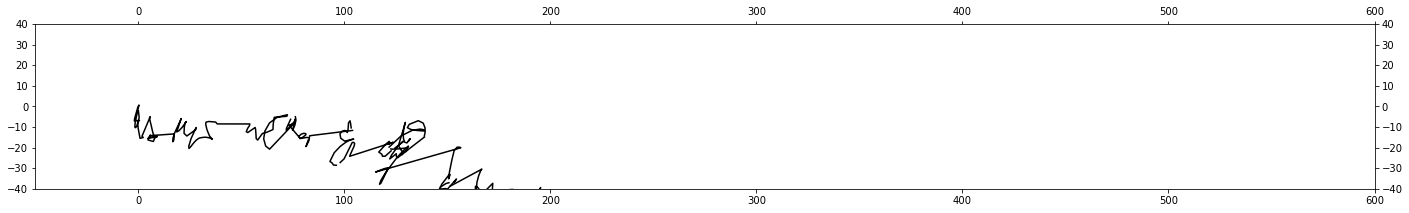

n_iter: 9250 of 15600, loss: -700.3780078125, timeElapsed: 23096.335386514664
n_iter: 9300 of 15600, loss: -699.6035070800781, timeElapsed: 23221.10296845436
n_iter: 9350 of 15600, loss: -692.015947265625, timeElapsed: 23346.90373969078
n_iter: 9400 of 15600, loss: -702.6814526367187, timeElapsed: 23472.368393421173


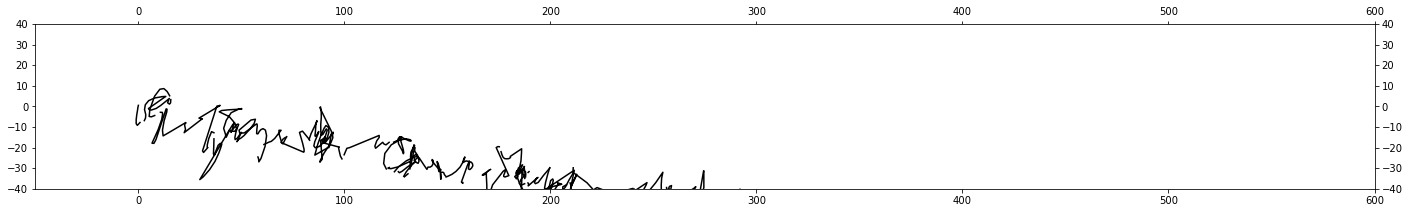

n_iter: 9450 of 15600, loss: -703.3793640136719, timeElapsed: 23599.52190041542
n_iter: 9500 of 15600, loss: -699.3757141113281, timeElapsed: 23724.52496123314
n_iter: 9550 of 15600, loss: -704.788330078125, timeElapsed: 23849.97466158867
n_iter: 9600 of 15600, loss: -704.1213635253906, timeElapsed: 23975.104944229126


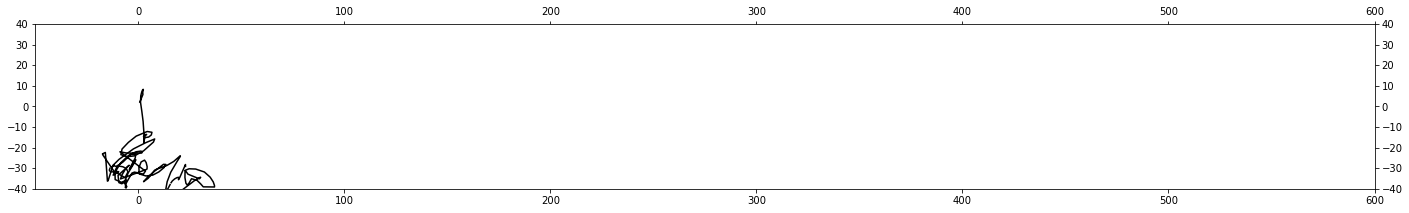

n_iter: 9650 of 15600, loss: -707.7937915039063, timeElapsed: 24101.905230998993
n_iter: 9700 of 15600, loss: -706.5161828613282, timeElapsed: 24227.528793096542
n_iter: 9750 of 15600, loss: -709.8905151367187, timeElapsed: 24352.514038801193
n_iter: 9800 of 15600, loss: -702.5759582519531, timeElapsed: 24477.971773147583


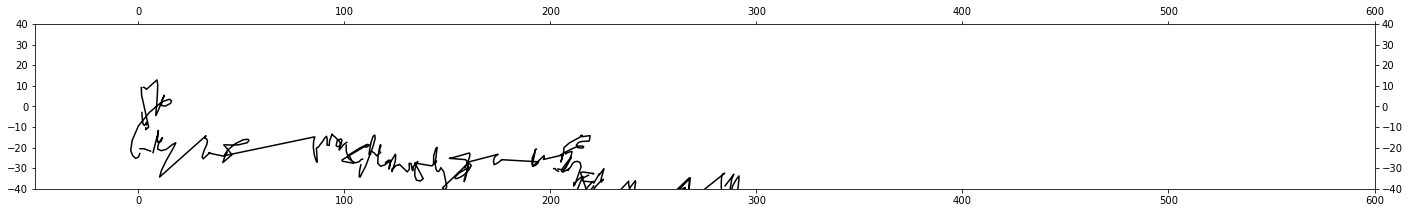

n_iter: 9850 of 15600, loss: -716.3486889648437, timeElapsed: 24605.940393447876
n_iter: 9900 of 15600, loss: -716.8985095214844, timeElapsed: 24730.426661252975
n_iter: 9950 of 15600, loss: -711.4819860839843, timeElapsed: 24856.480979919434
n_iter: 10000 of 15600, loss: -721.14765625, timeElapsed: 24982.31476044655


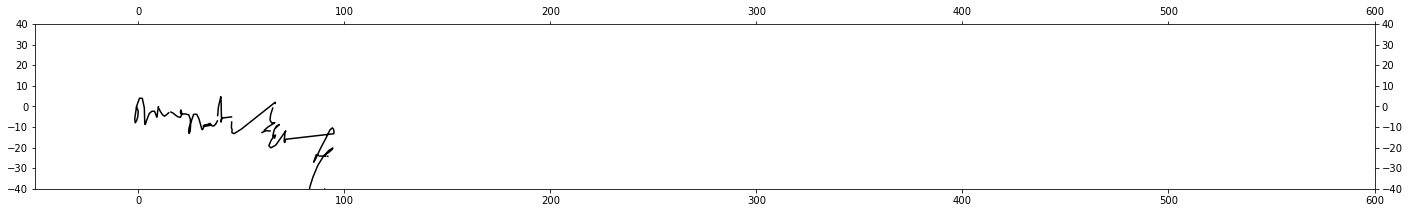

n_iter: 10050 of 15600, loss: -711.6741882324219, timeElapsed: 25108.713052749634
n_iter: 10100 of 15600, loss: -715.6396899414062, timeElapsed: 25234.78670334816
n_iter: 10150 of 15600, loss: -717.2962609863281, timeElapsed: 25359.59075474739
n_iter: 10200 of 15600, loss: -722.250869140625, timeElapsed: 25484.519863128662


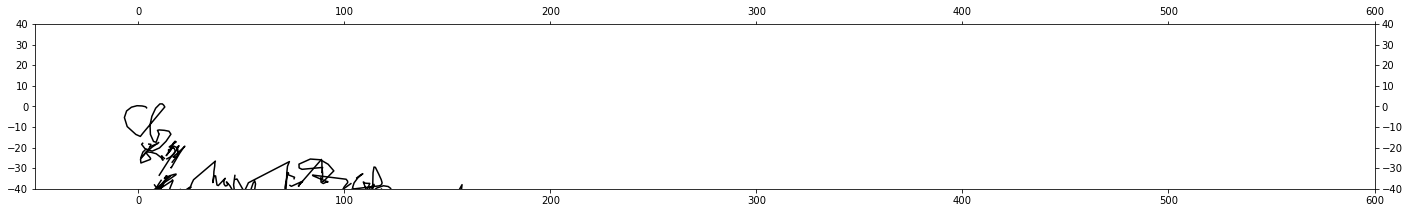

n_iter: 10250 of 15600, loss: -725.3278942871094, timeElapsed: 25610.570632219315
n_iter: 10300 of 15600, loss: -714.6350378417969, timeElapsed: 25735.851624011993
n_iter: 10350 of 15600, loss: -721.9630310058594, timeElapsed: 25860.522097826004
n_iter: 10400 of 15600, loss: -728.0944689941406, timeElapsed: 25986.569016695023


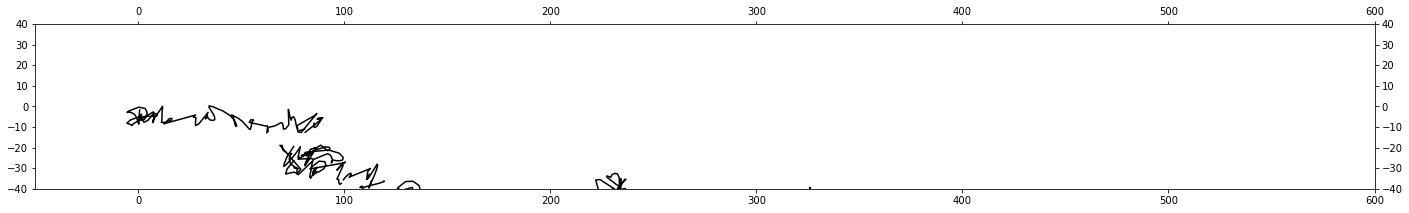

n_iter: 10450 of 15600, loss: -723.7705615234376, timeElapsed: 26114.042197942734
n_iter: 10500 of 15600, loss: -730.1838415527344, timeElapsed: 26239.499785661697
n_iter: 10550 of 15600, loss: -724.4384887695312, timeElapsed: 26364.67688369751
n_iter: 10600 of 15600, loss: -726.4725732421875, timeElapsed: 26489.686832666397


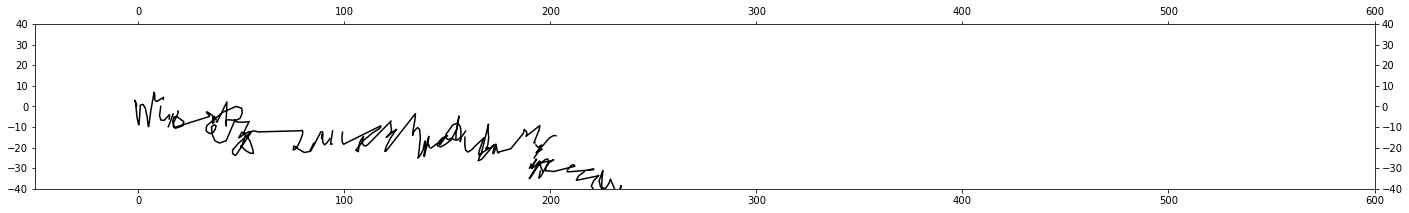

n_iter: 10650 of 15600, loss: -733.1566564941406, timeElapsed: 26616.82665038109
n_iter: 10700 of 15600, loss: -731.8331994628907, timeElapsed: 26743.07836008072
n_iter: 10750 of 15600, loss: -724.5244616699218, timeElapsed: 26869.228040456772
n_iter: 10800 of 15600, loss: -737.9790783691407, timeElapsed: 26994.87732052803


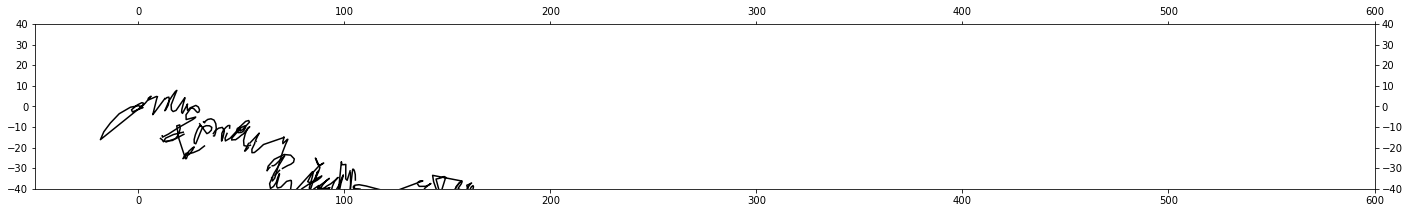

n_iter: 10850 of 15600, loss: -734.0699584960937, timeElapsed: 27121.76371407509
n_iter: 10900 of 15600, loss: -733.818369140625, timeElapsed: 27246.977258205414
n_iter: 10950 of 15600, loss: -739.9880334472656, timeElapsed: 27372.199227809906
n_iter: 11000 of 15600, loss: -736.7744677734376, timeElapsed: 27497.771720409393


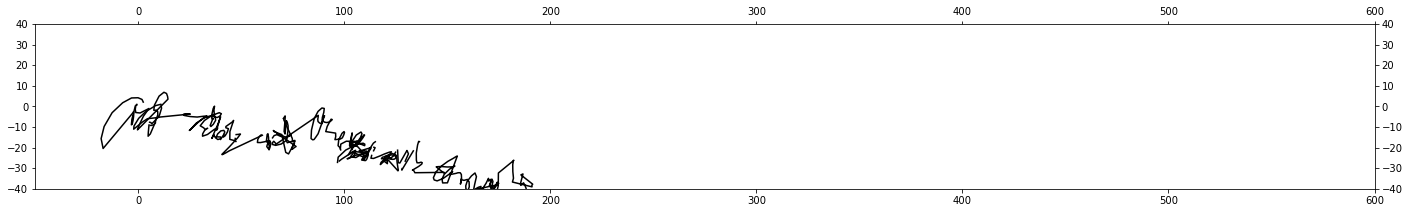

n_iter: 11050 of 15600, loss: -738.4381823730469, timeElapsed: 27625.85147547722
n_iter: 11100 of 15600, loss: -745.0805456542969, timeElapsed: 27751.700797080994
n_iter: 11150 of 15600, loss: -738.0050463867187, timeElapsed: 27876.800418376923
n_iter: 11200 of 15600, loss: -735.7492944335937, timeElapsed: 28002.62133359909


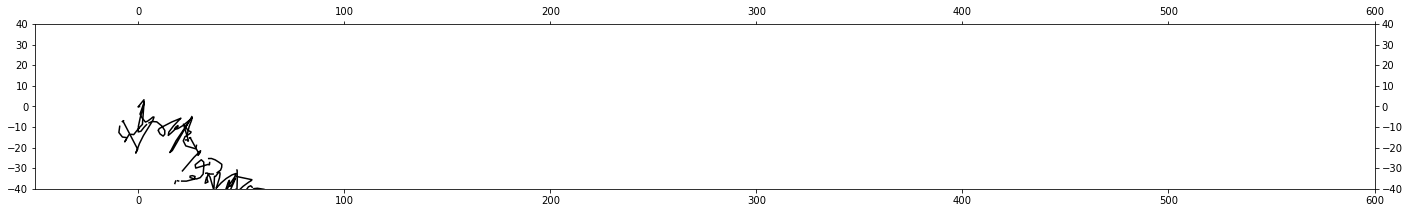

n_iter: 11250 of 15600, loss: -752.8483618164063, timeElapsed: 28130.397691488266
n_iter: 11300 of 15600, loss: -737.2428369140625, timeElapsed: 28255.8390083313
n_iter: 11350 of 15600, loss: -743.0589672851562, timeElapsed: 28381.713644981384
n_iter: 11400 of 15600, loss: -752.1589440917969, timeElapsed: 28507.160928487778


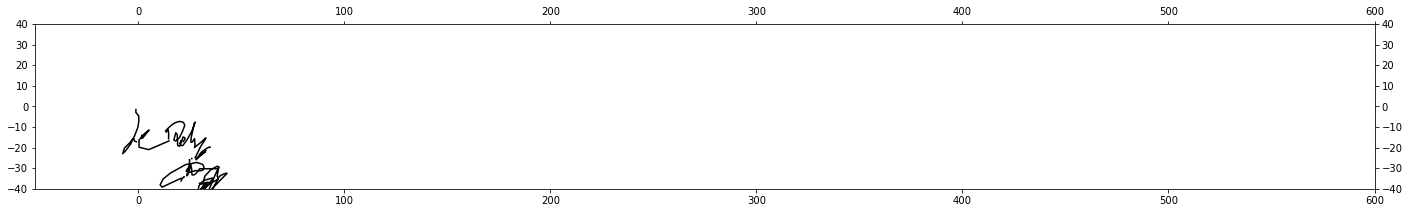

n_iter: 11450 of 15600, loss: -745.781806640625, timeElapsed: 28634.610294818878
n_iter: 11500 of 15600, loss: -747.0891101074219, timeElapsed: 28758.752715349197
n_iter: 11550 of 15600, loss: -753.4808471679687, timeElapsed: 28884.300149917603
n_iter: 11600 of 15600, loss: -749.5078112792969, timeElapsed: 29009.748820781708


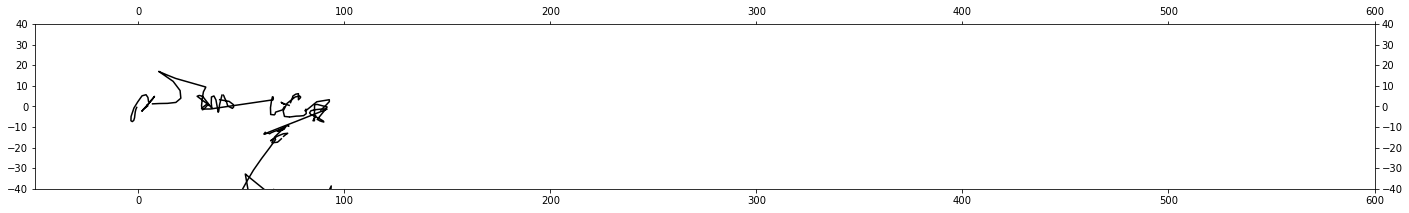

n_iter: 11650 of 15600, loss: -750.9564221191406, timeElapsed: 29135.967972517014
n_iter: 11700 of 15600, loss: -752.5134765625, timeElapsed: 29261.36636686325
n_iter: 11750 of 15600, loss: -751.2370715332031, timeElapsed: 29387.227870941162
n_iter: 11800 of 15600, loss: -760.771455078125, timeElapsed: 29512.556481838226


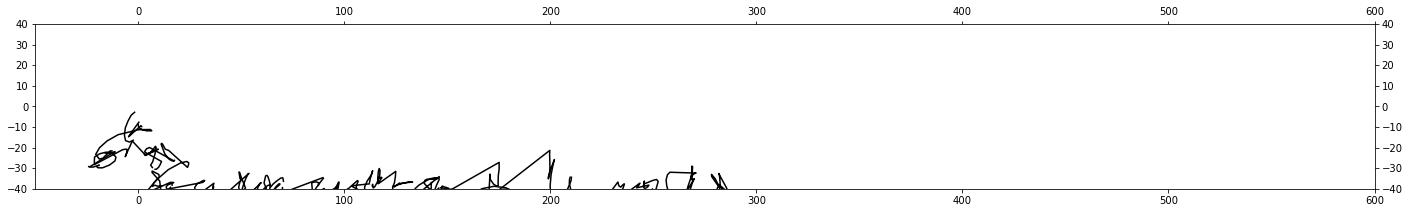

n_iter: 11850 of 15600, loss: -756.2353869628906, timeElapsed: 29639.30857348442
n_iter: 11900 of 15600, loss: -761.9712512207032, timeElapsed: 29764.599684238434
n_iter: 11950 of 15600, loss: -752.0630505371093, timeElapsed: 29889.997054576874
n_iter: 12000 of 15600, loss: -764.6446984863281, timeElapsed: 30016.297911643982


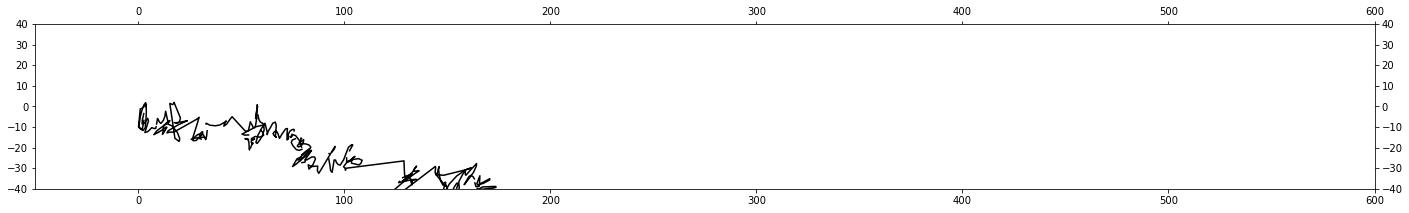

n_iter: 12050 of 15600, loss: -759.0951586914063, timeElapsed: 30143.36012005806
n_iter: 12100 of 15600, loss: -759.799892578125, timeElapsed: 30268.814338445663
n_iter: 12150 of 15600, loss: -762.9967712402344, timeElapsed: 30394.004625320435
n_iter: 12200 of 15600, loss: -772.4197521972657, timeElapsed: 30519.979825258255


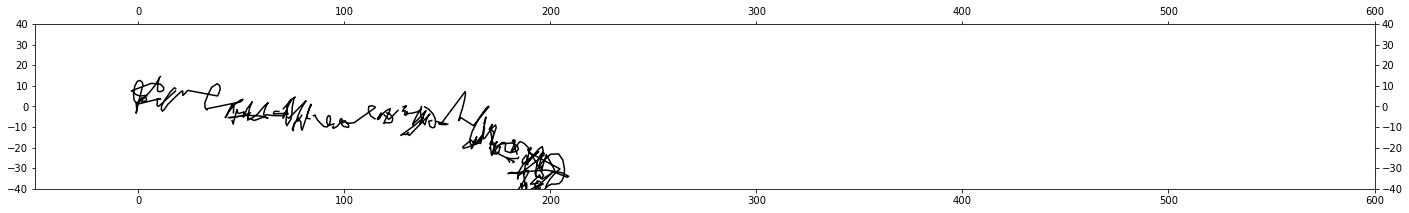

n_iter: 12250 of 15600, loss: -759.2919934082031, timeElapsed: 30647.45471382141
n_iter: 12300 of 15600, loss: -759.9834545898437, timeElapsed: 30771.818940877914
n_iter: 12350 of 15600, loss: -766.5097998046875, timeElapsed: 30896.600680351257
n_iter: 12400 of 15600, loss: -769.34138671875, timeElapsed: 31022.89196228981


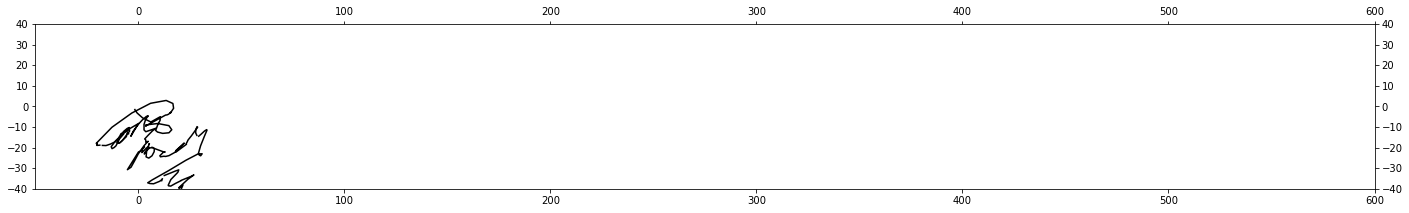

n_iter: 12450 of 15600, loss: -763.5860681152344, timeElapsed: 31149.539628744125
n_iter: 12500 of 15600, loss: -775.6628356933594, timeElapsed: 31275.655547618866
n_iter: 12550 of 15600, loss: -775.041650390625, timeElapsed: 31400.848839521408
n_iter: 12600 of 15600, loss: -770.9165209960937, timeElapsed: 31526.943536043167


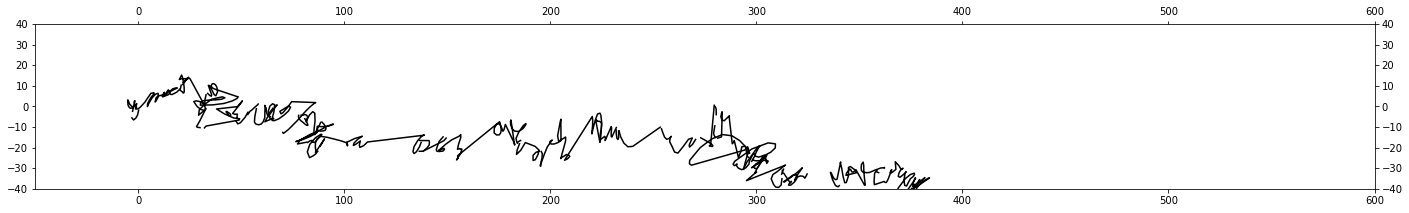

n_iter: 12650 of 15600, loss: -770.5501843261719, timeElapsed: 31653.98663663864
n_iter: 12700 of 15600, loss: -773.5143273925781, timeElapsed: 31779.399168252945
n_iter: 12750 of 15600, loss: -771.9316027832032, timeElapsed: 31903.90451312065
n_iter: 12800 of 15600, loss: -781.1809033203125, timeElapsed: 32029.164242982864


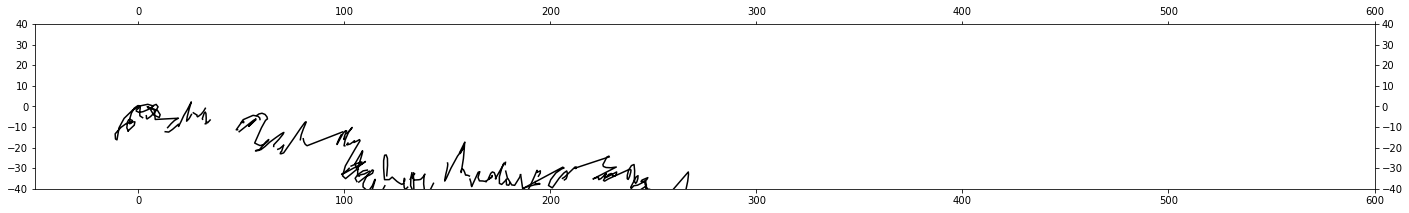

n_iter: 12850 of 15600, loss: -774.2031494140625, timeElapsed: 32155.54819893837
n_iter: 12900 of 15600, loss: -785.3931506347657, timeElapsed: 32281.336980819702
n_iter: 12950 of 15600, loss: -772.9810986328125, timeElapsed: 32406.127721309662
n_iter: 13000 of 15600, loss: -785.0711840820312, timeElapsed: 32531.544793128967


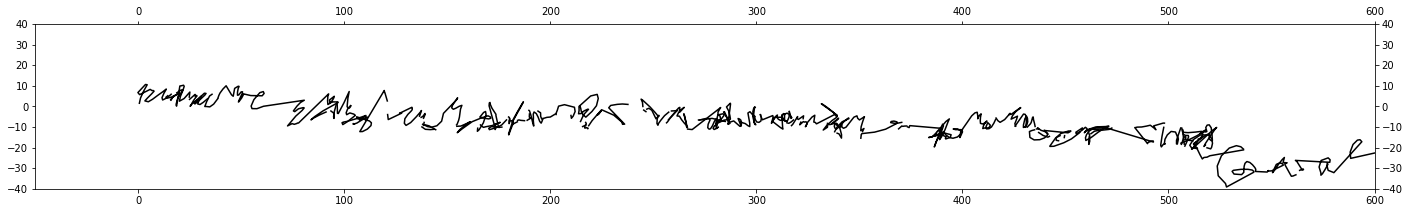

n_iter: 13050 of 15600, loss: -775.1016015625, timeElapsed: 32659.111813783646
n_iter: 13100 of 15600, loss: -784.9657238769531, timeElapsed: 32783.53240132332
n_iter: 13150 of 15600, loss: -787.8079516601563, timeElapsed: 32908.54665160179
n_iter: 13200 of 15600, loss: -778.49556640625, timeElapsed: 33034.36508846283


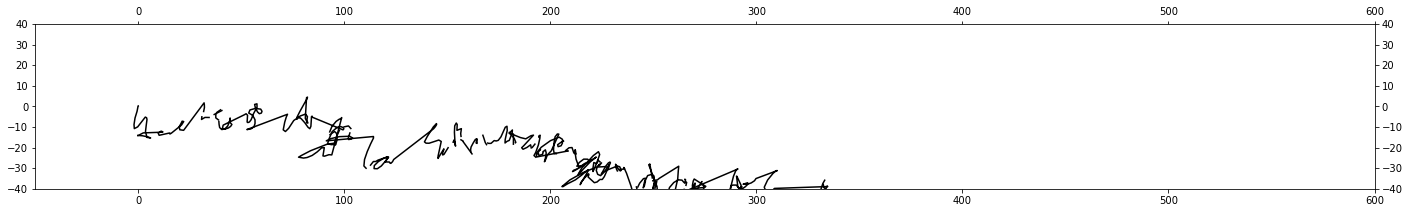

n_iter: 13250 of 15600, loss: -788.327412109375, timeElapsed: 33161.3617208004
n_iter: 13300 of 15600, loss: -787.4067138671875, timeElapsed: 33286.69424676895
n_iter: 13350 of 15600, loss: -786.8192407226562, timeElapsed: 33411.0464220047
n_iter: 13400 of 15600, loss: -788.3931164550781, timeElapsed: 33536.38439273834


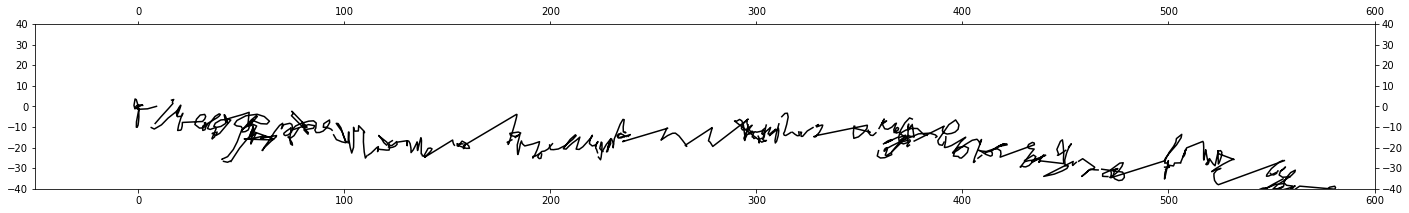

n_iter: 13450 of 15600, loss: -786.1645678710937, timeElapsed: 33662.76072239876
n_iter: 13500 of 15600, loss: -789.2237487792969, timeElapsed: 33788.24849319458
n_iter: 13550 of 15600, loss: -791.662529296875, timeElapsed: 33913.62663221359
n_iter: 13600 of 15600, loss: -800.6669897460938, timeElapsed: 34039.53331947327


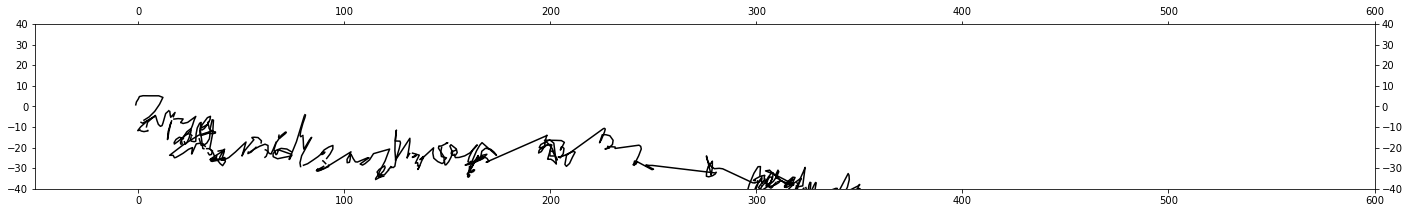

n_iter: 13650 of 15600, loss: -788.6733374023438, timeElapsed: 34166.853474378586
n_iter: 13700 of 15600, loss: -798.7509826660156, timeElapsed: 34292.16388106346
n_iter: 13750 of 15600, loss: -785.1622875976562, timeElapsed: 34417.537090063095
n_iter: 13800 of 15600, loss: -801.9832263183594, timeElapsed: 34542.44709968567


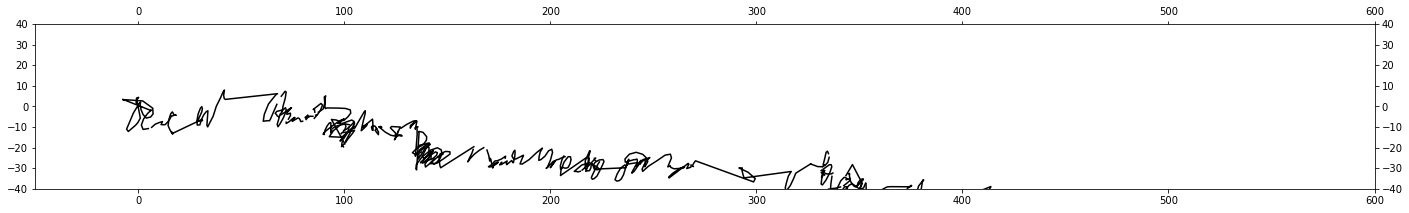

n_iter: 13850 of 15600, loss: -794.9652722167968, timeElapsed: 34669.60215950012
n_iter: 13900 of 15600, loss: -806.7134912109375, timeElapsed: 34795.2484023571
n_iter: 13950 of 15600, loss: -793.4184216308594, timeElapsed: 34920.72666621208
n_iter: 14000 of 15600, loss: -803.7933386230469, timeElapsed: 35046.98949813843


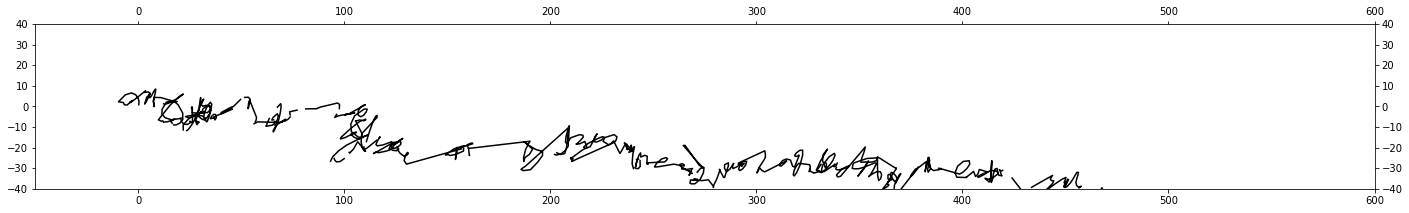

n_iter: 14050 of 15600, loss: -799.2320642089844, timeElapsed: 35173.65001773834
n_iter: 14100 of 15600, loss: -802.32130859375, timeElapsed: 35299.532843351364
n_iter: 14150 of 15600, loss: -799.4629711914063, timeElapsed: 35425.103586912155
n_iter: 14200 of 15600, loss: -807.9569592285156, timeElapsed: 35550.25125169754


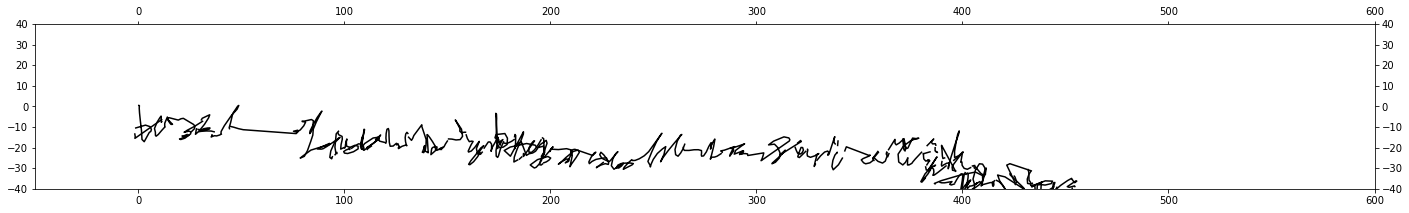

n_iter: 14250 of 15600, loss: -808.7590795898437, timeElapsed: 35677.024567604065
n_iter: 14300 of 15600, loss: -806.365732421875, timeElapsed: 35802.5562415123
n_iter: 14350 of 15600, loss: -803.7337707519531, timeElapsed: 35928.1059088707
n_iter: 14400 of 15600, loss: -810.6287255859374, timeElapsed: 36053.93347764015


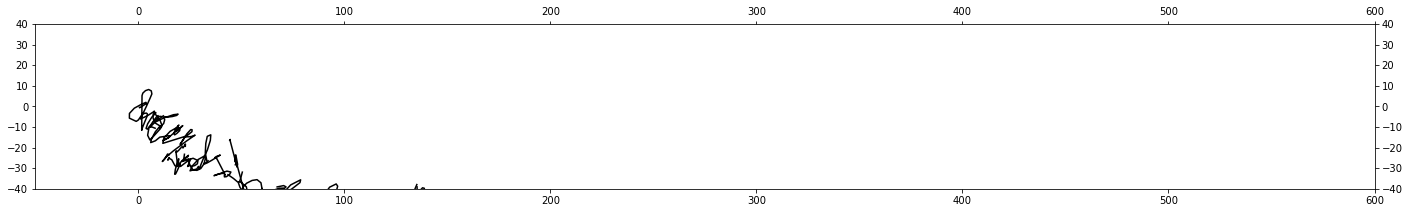

n_iter: 14450 of 15600, loss: -804.4888342285157, timeElapsed: 36180.5298435688
n_iter: 14500 of 15600, loss: -808.1868420410157, timeElapsed: 36306.26507806778
n_iter: 14550 of 15600, loss: -810.63521484375, timeElapsed: 36431.23289895058
n_iter: 14600 of 15600, loss: -816.232646484375, timeElapsed: 36556.09849715233


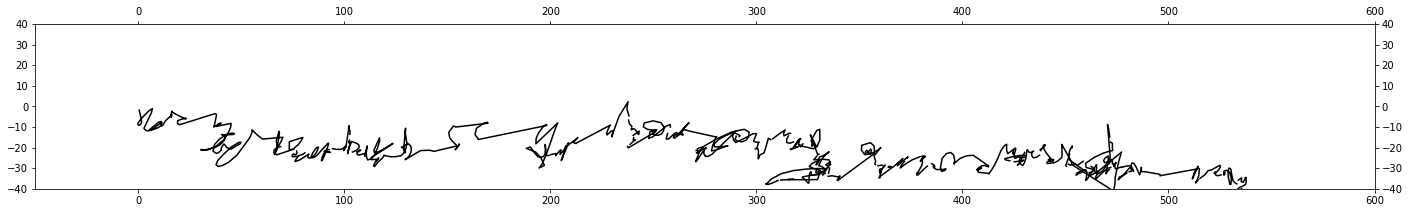

n_iter: 14650 of 15600, loss: -810.4598425292969, timeElapsed: 36683.348215818405
n_iter: 14700 of 15600, loss: -808.0284252929688, timeElapsed: 36809.156145334244
n_iter: 14750 of 15600, loss: -820.9971203613281, timeElapsed: 36934.887791633606
n_iter: 14800 of 15600, loss: -816.4936657714844, timeElapsed: 37060.04817843437


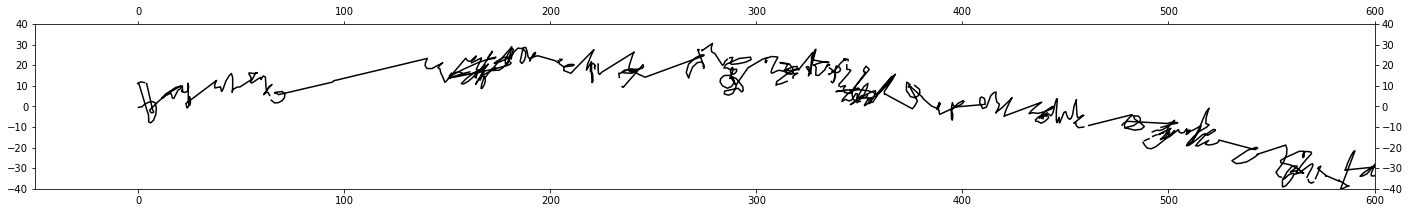

n_iter: 14850 of 15600, loss: -815.6793908691407, timeElapsed: 37186.65930724144
n_iter: 14900 of 15600, loss: -817.5146520996094, timeElapsed: 37313.04055285454
n_iter: 14950 of 15600, loss: -818.4275561523438, timeElapsed: 37437.8345849514
n_iter: 15000 of 15600, loss: -817.7888549804687, timeElapsed: 37563.118003606796


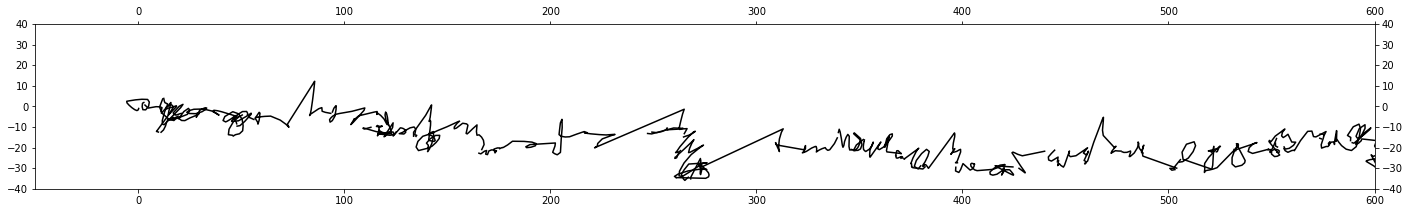

n_iter: 15050 of 15600, loss: -820.3267211914062, timeElapsed: 37689.39005923271
n_iter: 15100 of 15600, loss: -821.6701232910157, timeElapsed: 37814.219405412674
n_iter: 15150 of 15600, loss: -822.7713903808594, timeElapsed: 37938.69745373726
n_iter: 15200 of 15600, loss: -822.7106640625, timeElapsed: 38064.7607820034


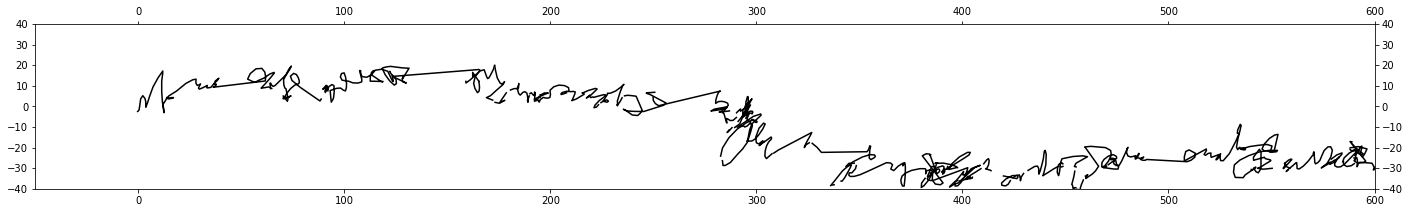

n_iter: 15250 of 15600, loss: -822.5779296875, timeElapsed: 38190.9366414547
n_iter: 15300 of 15600, loss: -825.4567407226563, timeElapsed: 38316.424119472504
n_iter: 15350 of 15600, loss: -823.2834020996094, timeElapsed: 38441.32775473595
n_iter: 15400 of 15600, loss: -826.1790087890626, timeElapsed: 38566.86378479004


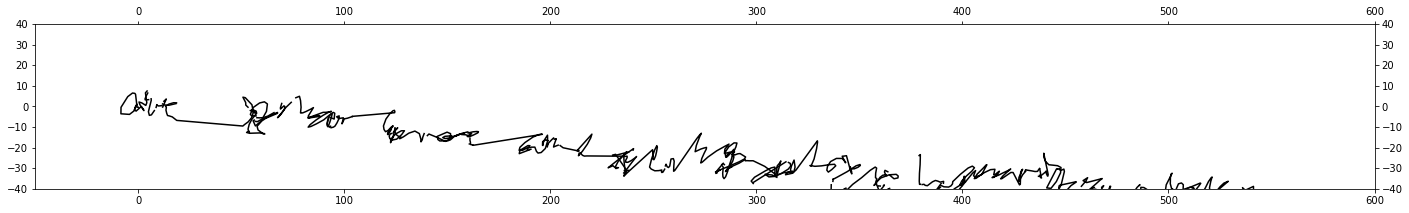

n_iter: 15450 of 15600, loss: -835.8577783203125, timeElapsed: 38693.56741952896
n_iter: 15500 of 15600, loss: -827.0562878417969, timeElapsed: 38819.369911432266
n_iter: 15550 of 15600, loss: -820.4049243164062, timeElapsed: 38943.23965930939


<Figure size 432x288 with 0 Axes>

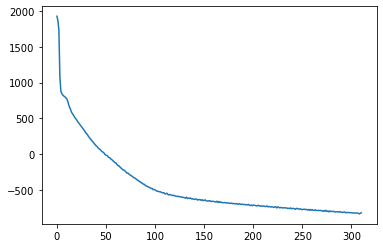

In [12]:
print_every = 50
draw_every = 200
n_epochs = 200
n_iters = 0
losses = []
total_loss = 0

optim = torch.optim.Adam(m.parameters(), lr = 0.00001)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, drop_last=True)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size, drop_last=True)

h0=torch.zeros(1, batch_size, hidden_size, device=device)
c0=torch.zeros(1, batch_size, hidden_size, device=device)

import time

start = time.time()

for i in range(n_epochs):
    for strokes, stroke_lens, mask in train_dataloader:
        loss = train(
            model=m, 
            input_strokes=strokes.to(device),
            stroke_lengths=stroke_lens.to(device),
            input_mask=mask.to(device),
            optimizer=optim,
            h0=h0, c0=c0)
        
        total_loss += loss
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs}, loss: {losses[-1]}, timeElapsed: {time.time() - start}")
            torch.save({
                    'epoch': i,
                    'model_state_dict': m.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'loss': losses[-1],
                    }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/prediction_logsumexp_std_vctnll.pt")

        if n_iters % draw_every == 0:
            sample_drawing()
            
        n_iters += 1
        
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses[1:])

n_iter: 15600 of 15600, loss: -834.765830078125, timeElapsed: 39068.10226202011


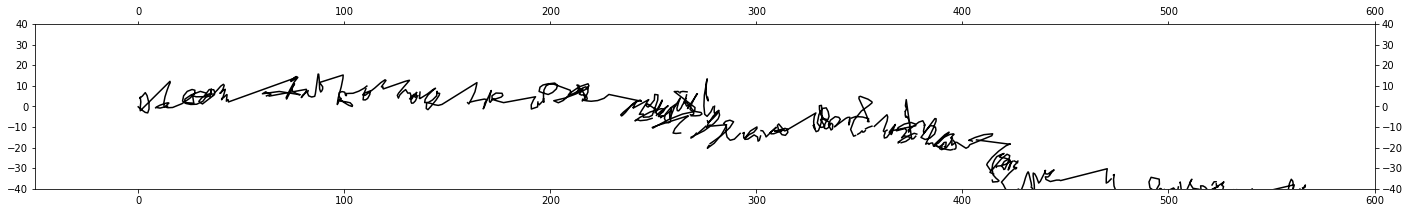

n_iter: 15650 of 15600, loss: -830.3140295410157, timeElapsed: 39195.92570710182
n_iter: 15700 of 15600, loss: -830.7283618164063, timeElapsed: 39321.29543209076
n_iter: 15750 of 15600, loss: -836.6507189941407, timeElapsed: 39446.68594169617
n_iter: 15800 of 15600, loss: -834.7324694824218, timeElapsed: 39572.58529782295


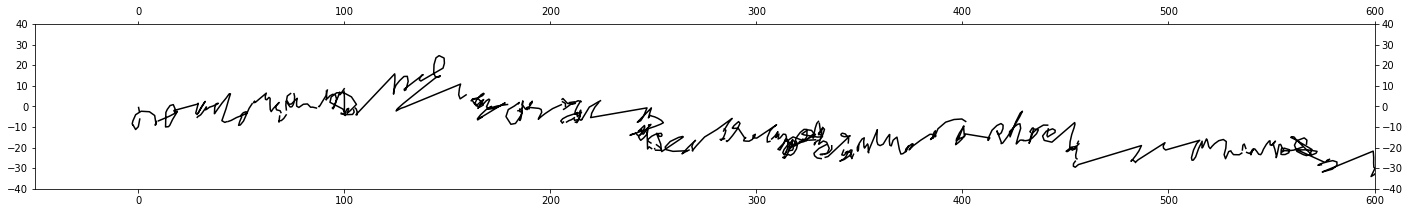

n_iter: 15850 of 15600, loss: -831.8975610351563, timeElapsed: 39698.58934497833
n_iter: 15900 of 15600, loss: -834.6608654785156, timeElapsed: 39823.547278642654
n_iter: 15950 of 15600, loss: -837.4927746582031, timeElapsed: 39949.06833744049
n_iter: 16000 of 15600, loss: -833.23611328125, timeElapsed: 40074.60483932495


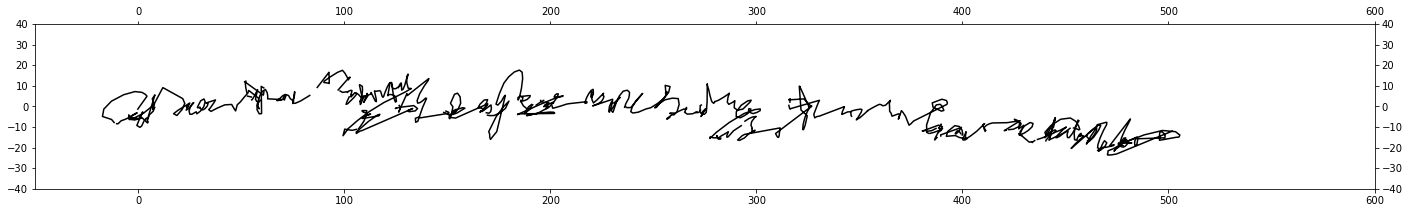

n_iter: 16050 of 15600, loss: -840.0389147949219, timeElapsed: 40201.27326798439
n_iter: 16100 of 15600, loss: -835.5478308105469, timeElapsed: 40326.020124435425
n_iter: 16150 of 15600, loss: -843.5369689941406, timeElapsed: 40450.80213046074
n_iter: 16200 of 15600, loss: -842.133544921875, timeElapsed: 40575.347615003586


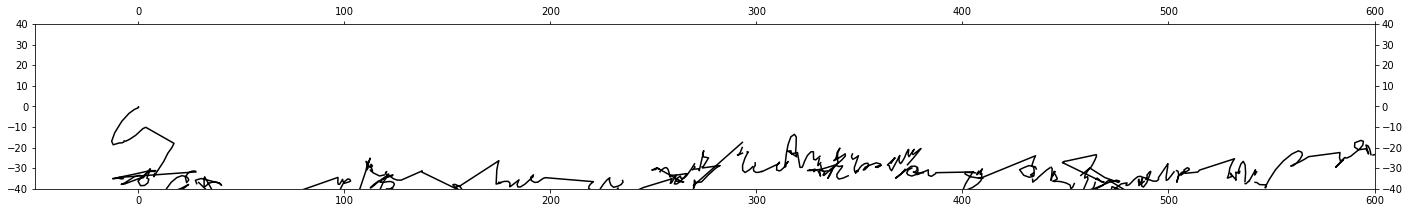

n_iter: 16250 of 15600, loss: -843.2084777832031, timeElapsed: 40702.32331585884
n_iter: 16300 of 15600, loss: -838.0251220703125, timeElapsed: 40826.90523266792
n_iter: 16350 of 15600, loss: -841.2976330566406, timeElapsed: 40951.32425928116
n_iter: 16400 of 15600, loss: -848.9630749511718, timeElapsed: 41076.859473228455


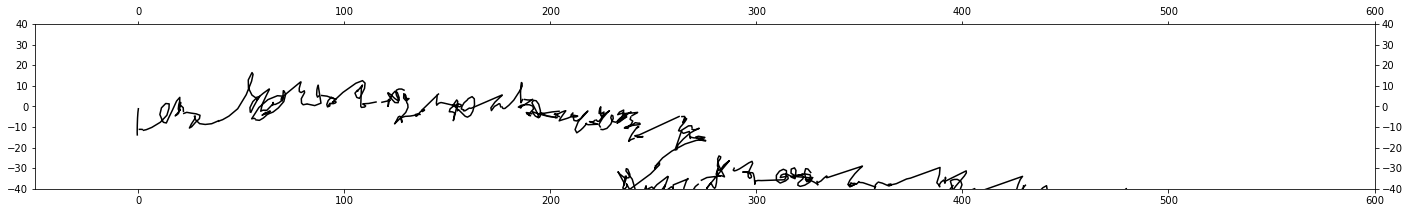

n_iter: 16450 of 15600, loss: -841.7865051269531, timeElapsed: 41203.59266209602
n_iter: 16500 of 15600, loss: -845.415625, timeElapsed: 41329.47666788101
n_iter: 16550 of 15600, loss: -844.16486328125, timeElapsed: 41453.92307829857
n_iter: 16600 of 15600, loss: -849.0342358398437, timeElapsed: 41579.05887937546


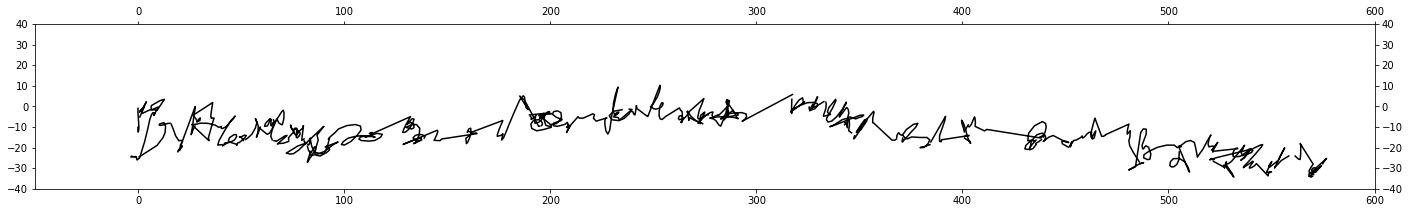

n_iter: 16650 of 15600, loss: -842.9299670410156, timeElapsed: 41705.86465907097
n_iter: 16700 of 15600, loss: -857.2387133789063, timeElapsed: 41830.66167497635
n_iter: 16750 of 15600, loss: -848.3845666503906, timeElapsed: 41955.80682873726
n_iter: 16800 of 15600, loss: -847.554384765625, timeElapsed: 42080.736713171005


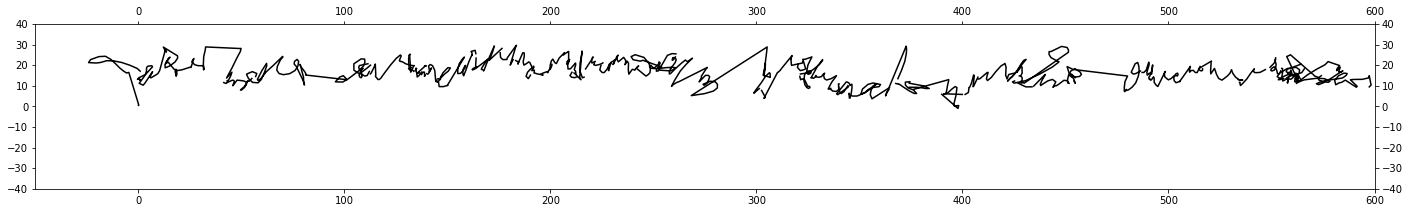

n_iter: 16850 of 15600, loss: -854.8013745117188, timeElapsed: 42208.172468185425
n_iter: 16900 of 15600, loss: -851.4405749511719, timeElapsed: 42333.2369081974
n_iter: 16950 of 15600, loss: -854.7101953125, timeElapsed: 42458.82827544212
n_iter: 17000 of 15600, loss: -850.4474450683593, timeElapsed: 42584.62806940079


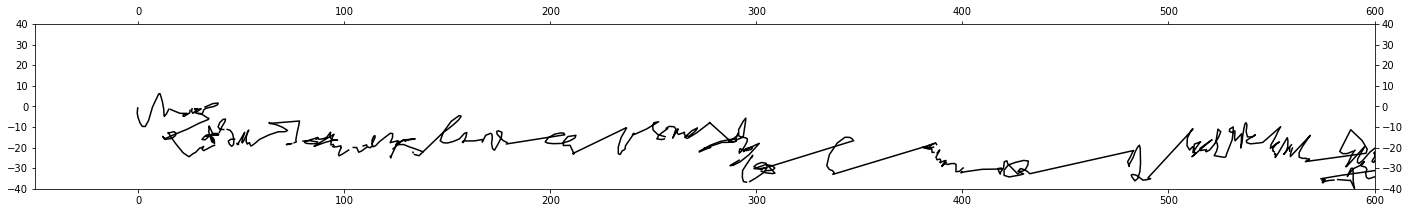

n_iter: 17050 of 15600, loss: -856.1828979492187, timeElapsed: 42712.09430718422
n_iter: 17100 of 15600, loss: -846.280537109375, timeElapsed: 42836.637627363205
n_iter: 17150 of 15600, loss: -864.0548217773437, timeElapsed: 42961.627920389175
n_iter: 17200 of 15600, loss: -856.4225146484375, timeElapsed: 43086.81891989708


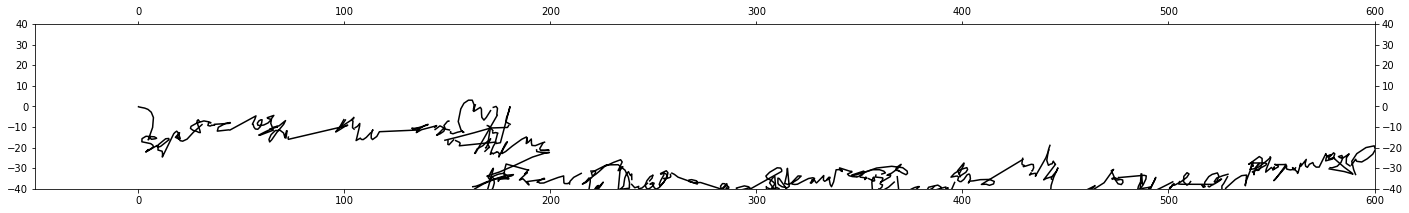

n_iter: 17250 of 15600, loss: -861.2440454101562, timeElapsed: 43213.43154788017
n_iter: 17300 of 15600, loss: -853.8914978027344, timeElapsed: 43338.7031083107
n_iter: 17350 of 15600, loss: -859.5743981933593, timeElapsed: 43463.24611091614
n_iter: 17400 of 15600, loss: -861.8793298339843, timeElapsed: 43589.05559468269


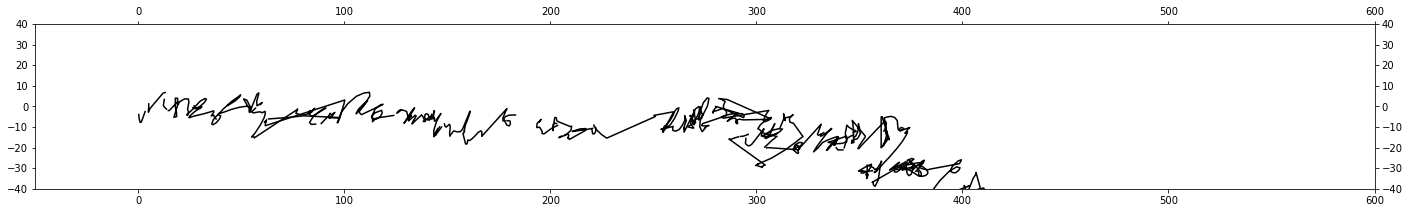

n_iter: 17450 of 15600, loss: -860.3857312011719, timeElapsed: 43715.62045240402
n_iter: 17500 of 15600, loss: -866.8644946289063, timeElapsed: 43841.347052812576
n_iter: 17550 of 15600, loss: -854.9627416992188, timeElapsed: 43966.3966023922
n_iter: 17600 of 15600, loss: -870.4002026367187, timeElapsed: 44092.06196808815


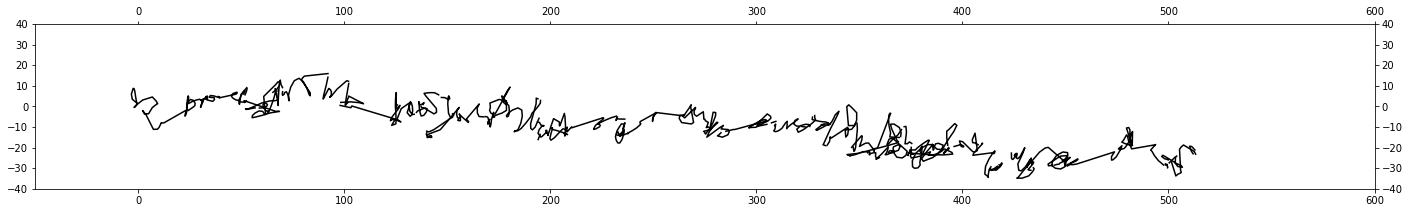

n_iter: 17650 of 15600, loss: -857.6466955566407, timeElapsed: 44218.83574128151
n_iter: 17700 of 15600, loss: -865.7231286621094, timeElapsed: 44344.60345387459
n_iter: 17750 of 15600, loss: -864.45548828125, timeElapsed: 44470.624553442
n_iter: 17800 of 15600, loss: -864.5084033203125, timeElapsed: 44596.077203035355


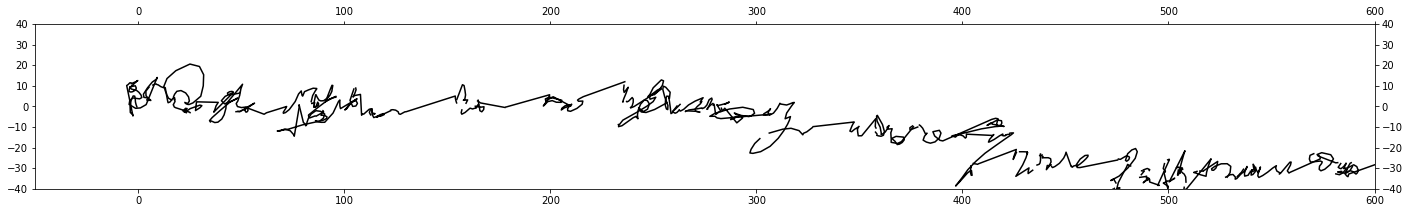

n_iter: 17850 of 15600, loss: -868.8771057128906, timeElapsed: 44722.91530132294
n_iter: 17900 of 15600, loss: -865.4510778808594, timeElapsed: 44847.23887324333
n_iter: 17950 of 15600, loss: -866.6611059570313, timeElapsed: 44972.571696043015
n_iter: 18000 of 15600, loss: -870.9224145507812, timeElapsed: 45097.76947140694


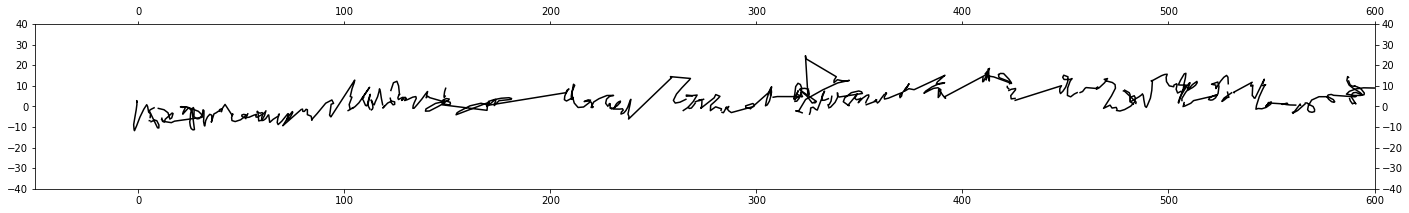

n_iter: 18050 of 15600, loss: -872.4024267578125, timeElapsed: 45223.21154713631
n_iter: 18100 of 15600, loss: -866.3016589355469, timeElapsed: 45348.102400541306
n_iter: 18150 of 15600, loss: -872.1428247070312, timeElapsed: 45474.27126669884
n_iter: 18200 of 15600, loss: -864.6278381347656, timeElapsed: 45599.0856821537


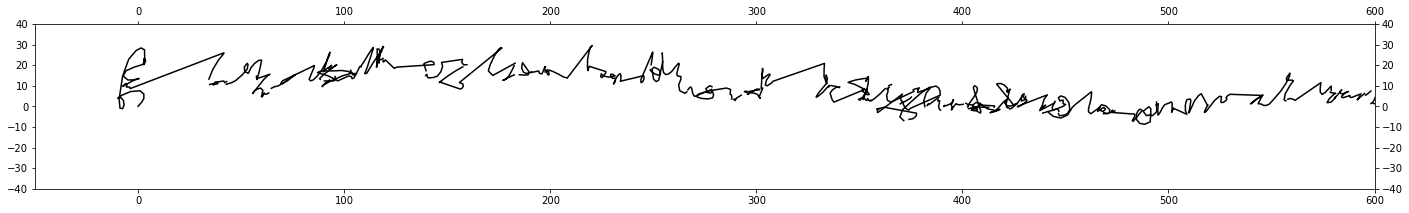

n_iter: 18250 of 15600, loss: -877.8292370605469, timeElapsed: 45727.380830049515
n_iter: 18300 of 15600, loss: -867.9345642089844, timeElapsed: 45852.938969135284
n_iter: 18350 of 15600, loss: -877.7651330566406, timeElapsed: 45978.29890537262
n_iter: 18400 of 15600, loss: -870.5559777832032, timeElapsed: 46103.177084207535


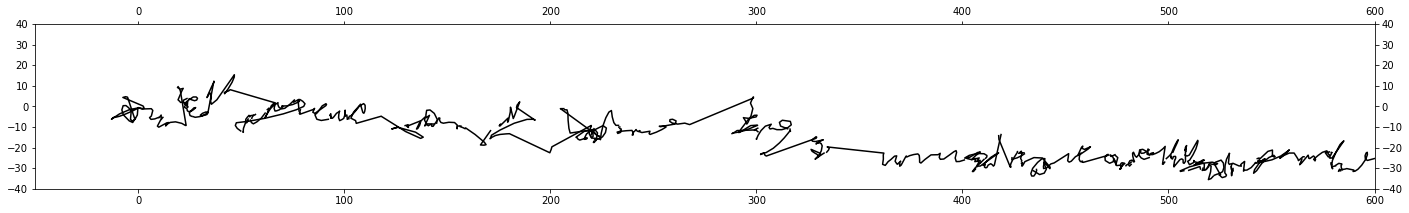

n_iter: 18450 of 15600, loss: -876.8096264648437, timeElapsed: 46230.0332839489
n_iter: 18500 of 15600, loss: -872.4013745117187, timeElapsed: 46355.75528216362
n_iter: 18550 of 15600, loss: -876.9705786132813, timeElapsed: 46480.99897432327
n_iter: 18600 of 15600, loss: -878.4925415039063, timeElapsed: 46606.85470199585


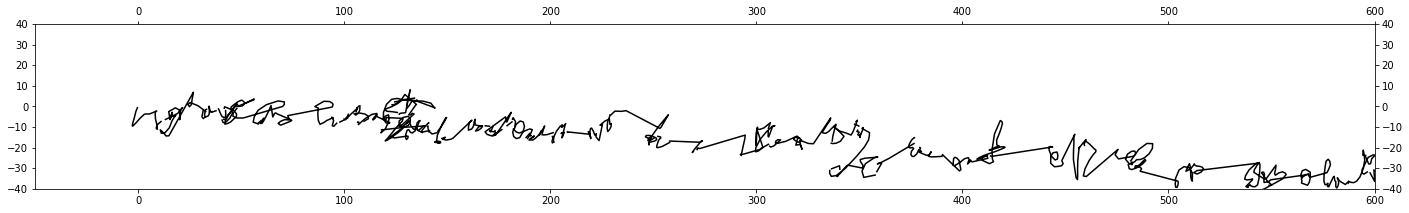

n_iter: 18650 of 15600, loss: -876.0287316894531, timeElapsed: 46733.38077831268
n_iter: 18700 of 15600, loss: -879.3608422851562, timeElapsed: 46858.55703878403
n_iter: 18750 of 15600, loss: -887.2625244140625, timeElapsed: 46984.455343961716
n_iter: 18800 of 15600, loss: -874.9679736328125, timeElapsed: 47110.08531332016


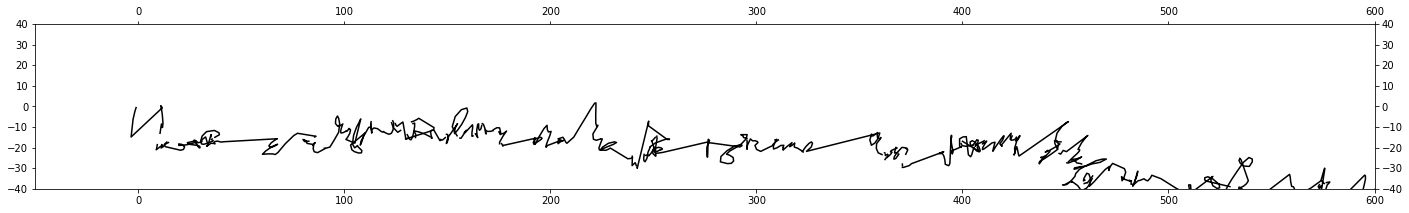

n_iter: 18850 of 15600, loss: -883.42041015625, timeElapsed: 47237.648601293564
n_iter: 18900 of 15600, loss: -875.8939270019531, timeElapsed: 47363.246228694916
n_iter: 18950 of 15600, loss: -887.7748852539063, timeElapsed: 47487.47951602936
n_iter: 19000 of 15600, loss: -883.8402490234375, timeElapsed: 47612.7398648262


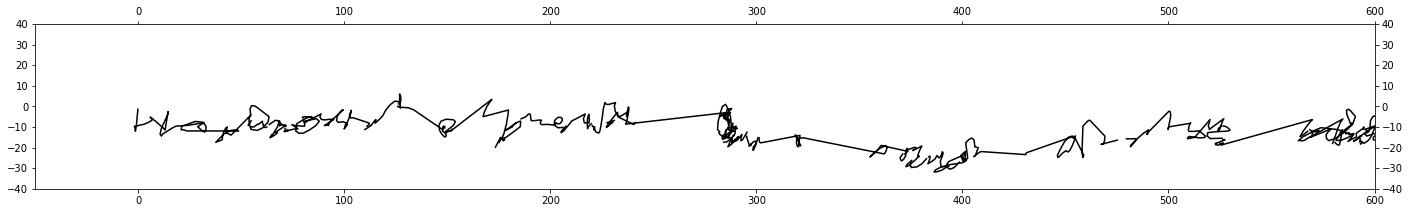

n_iter: 19050 of 15600, loss: -878.8680871582031, timeElapsed: 47738.578951358795
n_iter: 19100 of 15600, loss: -885.3465673828125, timeElapsed: 47864.82200503349
n_iter: 19150 of 15600, loss: -884.3795715332031, timeElapsed: 47989.890639066696
n_iter: 19200 of 15600, loss: -879.865693359375, timeElapsed: 48115.66067361832


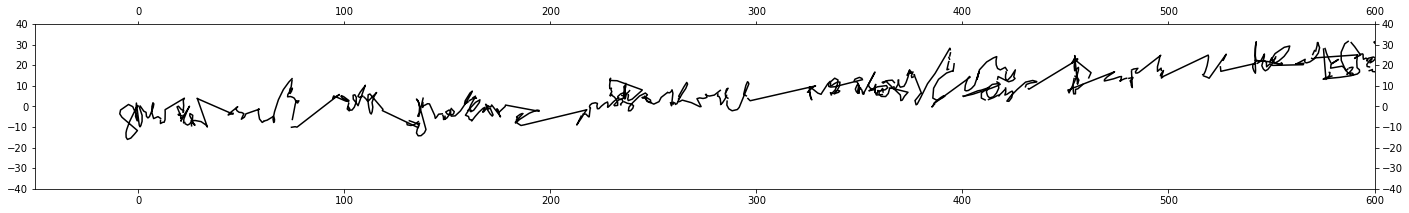

n_iter: 19250 of 15600, loss: -883.2773168945313, timeElapsed: 48242.18286919594
n_iter: 19300 of 15600, loss: -893.5658557128907, timeElapsed: 48367.571221113205
n_iter: 19350 of 15600, loss: -881.860576171875, timeElapsed: 48493.117621183395
n_iter: 19400 of 15600, loss: -883.4857775878907, timeElapsed: 48618.56429862976


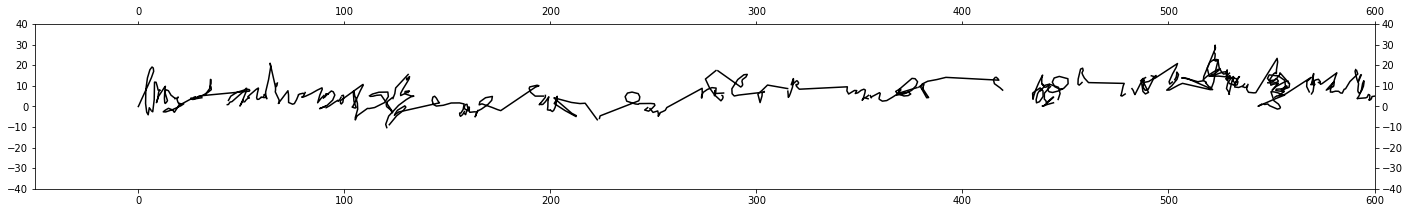

n_iter: 19450 of 15600, loss: -887.9456298828125, timeElapsed: 48745.04678988457
n_iter: 19500 of 15600, loss: -889.11740234375, timeElapsed: 48869.93996953964
n_iter: 19550 of 15600, loss: -892.2829455566406, timeElapsed: 48994.81449317932
n_iter: 19600 of 15600, loss: -887.9391979980469, timeElapsed: 49120.65885066986


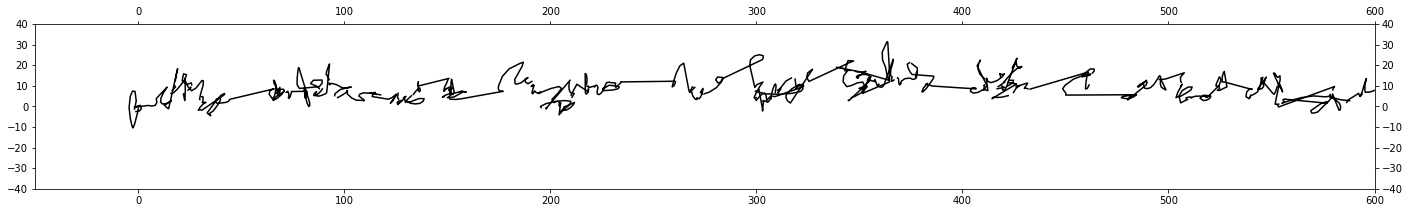

In [ ]:
for i in range(n_epochs):
    for strokes, stroke_lens, mask in train_dataloader:
        loss = train(
            model=m, 
            input_strokes=strokes.to(device),
            stroke_lengths=stroke_lens.to(device),
            input_mask=mask.to(device),
            optimizer=optim,
            h0=h0, c0=c0)
        
        total_loss += loss
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs}, loss: {losses[-1]}, timeElapsed: {time.time() - start}")
            torch.save({
                    'epoch': i,
                    'model_state_dict': m.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'loss': losses[-1],
                    }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/prediction_logsumexp_std_vctnll.pt")

        if n_iters % draw_every == 0:
            sample_drawing()
            
        n_iters += 1
        
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses[1:])

In [ ]:
for i in range(n_epochs):
    for strokes, stroke_lens, mask in train_dataloader:
        loss = train(
            model=m, 
            input_strokes=strokes.to(device),
            stroke_lengths=stroke_lens.to(device),
            input_mask=mask.to(device),
            optimizer=optim,
            h0=h0, c0=c0)
        
        total_loss += loss
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs + n_iters}, loss: {losses[-1]}, timeElapsed: {time.time() - start}")
            torch.save({
                    'epoch': i,
                    'model_state_dict': m.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'loss': losses[-1],
                    }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/prediction_logsumexp_std_vctnll.pt")
        n_iters += 1
        
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses[1:])

In [ ]:
def sample_drawing():
    timestamps = 1200

    with torch.no_grad():
        h1n=torch.zeros(1, 1, hidden_size, device=device)
        c1n=torch.zeros(1, 1, hidden_size, device=device)
        h2n=torch.zeros(1, 1, hidden_size, device=device)
        c2n=torch.zeros(1, 1, hidden_size, device=device)
        h3n=torch.zeros(1, 1, hidden_size, device=device)
        c3n=torch.zeros(1, 1, hidden_size, device=device)
        predictions = torch.zeros(timestamps, 3, device=device)
        predictions[0, 2] = 1
        for i in range(timestamps-1):
            x = predictions[i].unsqueeze(0).unsqueeze(0)
            
            out1, (h1n, c1n) = m.lstm1(x, (h1n, c1n))
            out2, (h2n, c2n) = m.lstm2(torch.cat((x, out1), -1), (h2n, c2n))
            out3, (h3n, c3n) = m.lstm3(torch.cat((x, out2), -1), (h3n, c3n))
            input4 = torch.cat((out1, out2, out3), -1)
            params = m.linear(input4)[0]

            es = 1/(1 + torch.exp(params[:,-1]))
            pis = nn.Softmax(1)(params[:,0:n_mixtures])
            mus = params[:, n_mixtures:3*n_mixtures].reshape(-1, n_mixtures, 2)
            sigmas = torch.exp(params[:, 3*n_mixtures:5*n_mixtures].reshape(-1, n_mixtures, 2))
            phos = torch.tanh(params[:, 5*n_mixtures:6*n_mixtures].reshape(-1, n_mixtures, 1))

            covs = torch.zeros(n_mixtures, 2, 2, device=device)
            tol = torch.tensor(0.000000001, device=device)
            covs[:,0,0] = sigmas[:,:,0] ** 2
            covs[:,0,1] = sigmas[:,:,0] * sigmas[:,:,1] * phos[:,:,0]
            covs[:,1,0] = covs[:,0,1]
            covs[:,1,1] = sigmas[:,:,1] ** 2

            sample_index = np.random.choice(
                range(n_mixtures),
                p = pis.squeeze().cpu().numpy())

            pen_off = np.random.binomial(1,es.item())

            sample_point = np.random.multivariate_normal(
                mus.squeeze()[sample_index].cpu().numpy(),
                covs[sample_index].cpu().numpy())

            predictions[i+1, 0] = sample_point[0]
            predictions[i+1, 1] = sample_point[1]
            predictions[i+1, 2] = pen_off
            
        predictions[1:, 0:2] *= std
        predictions[1:, 0:2] += means

    drawing.draw(predictions.cpu(), align_strokes=False, denoise_strokes=False, plot_end_points=False)


In [ ]:
for i in range(20):
    sample_drawing()

n_iter: 22500 of 4375, loss: -864.3271037597656, timeElapsed: 146.87345504760742
n_iter: 23000 of 4375, loss: -874.6805788574219, timeElapsed: 326.18258452415466
n_iter: 23500 of 4375, loss: -876.6286329345703, timeElapsed: 505.77893924713135
n_iter: 24000 of 4375, loss: -879.0949903564454, timeElapsed: 685.5430738925934
n_iter: 24500 of 4375, loss: -887.3768635253906, timeElapsed: 865.1040363311768
n_iter: 25000 of 4375, loss: -884.179810546875, timeElapsed: 1044.1250612735748
n_iter: 25500 of 4375, loss: -897.1061680908203, timeElapsed: 1224.0299060344696


<Figure size 432x288 with 0 Axes>

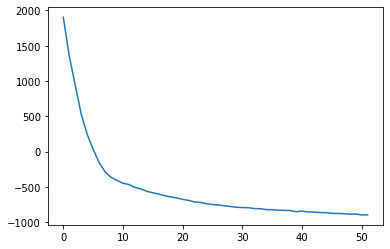

In [52]:
n_epochs = 7
import time

start = time.time()

for i in range(n_epochs):
    for strokes, stroke_lens in train_dataloader:
        loss = train(
            model=m, 
            input_strokes=strokes.to(device),
            stroke_lengths=stroke_lens,
            optimizer=optim,
            h0=h0, c0=c0)
        
        total_loss += loss
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs}, loss: {losses[-1]}, timeElapsed: {time.time() - start}")
            torch.save({
                    'epoch': i,
                    'model_state_dict': m.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'loss': losses[-1],
                    }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/model_with_padding.pt")
        n_iters += 1
        
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses[1:])

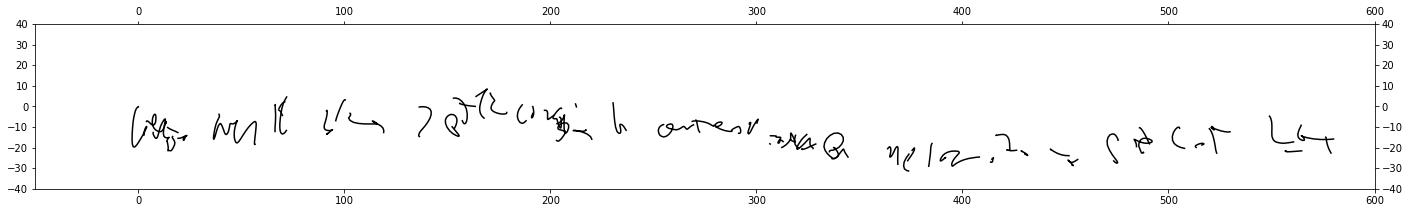

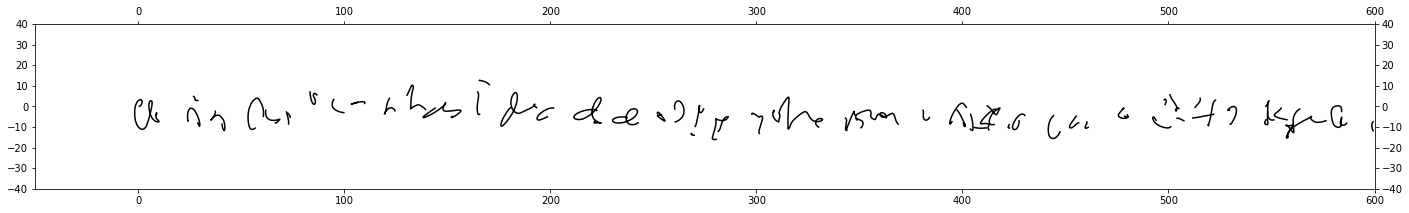

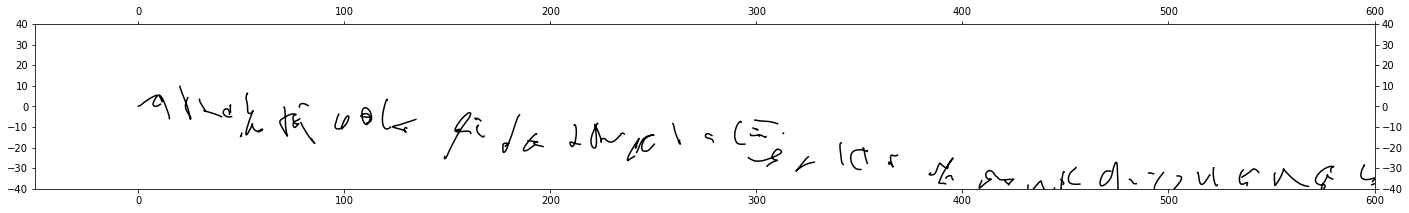

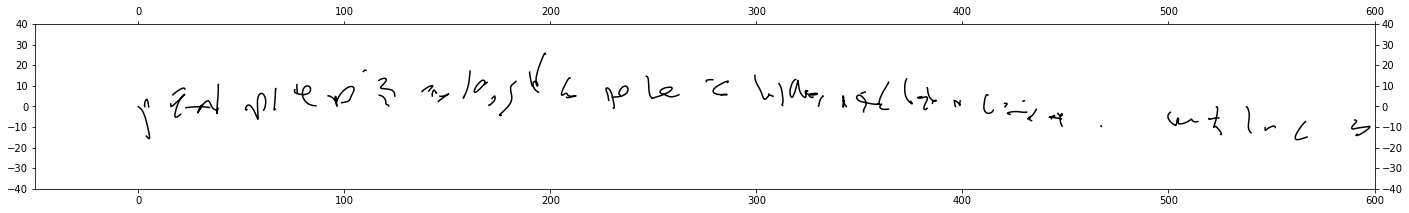

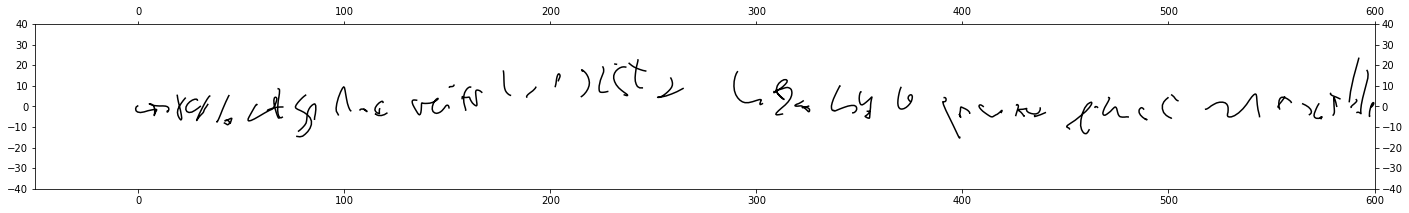

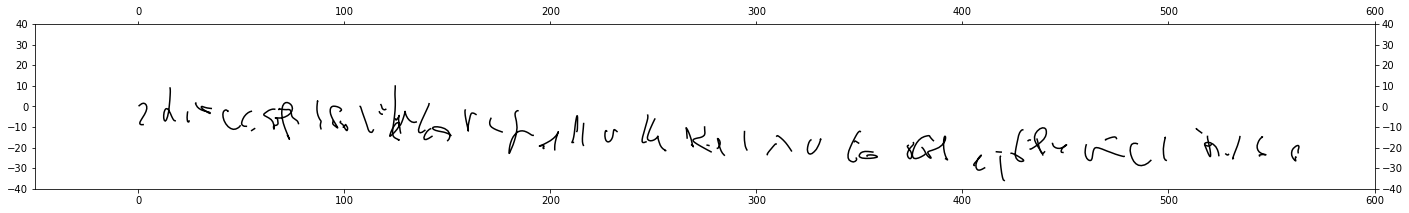

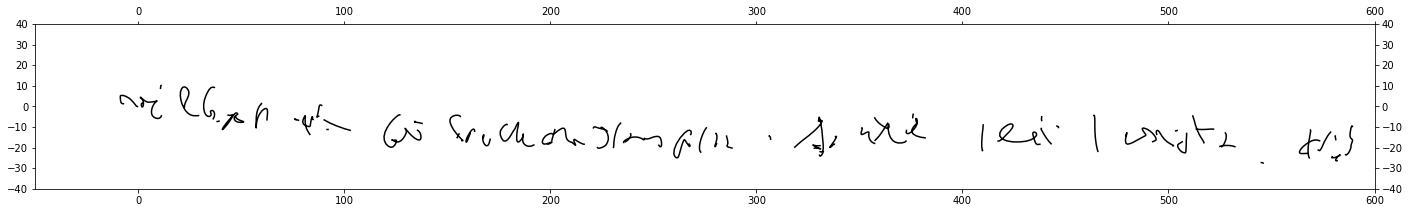

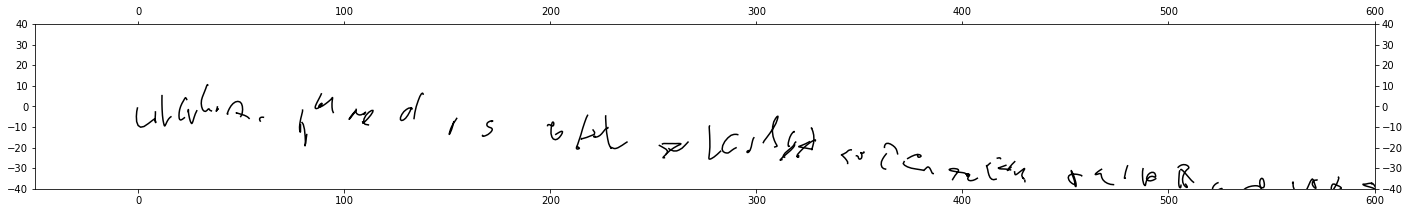

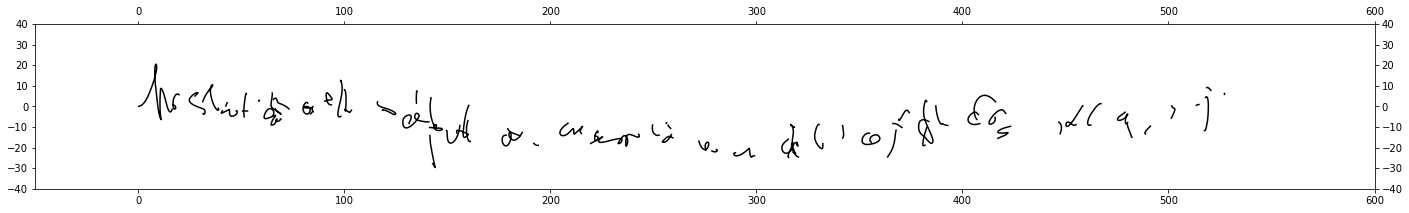

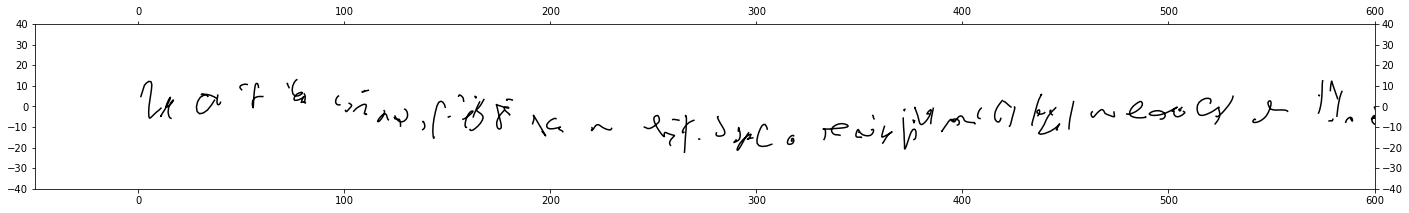

In [53]:
for i in range(10):
    sample_drawing()

n_iter: 0 of 30000, loss: 3.847310302734375, timeElapsed: 0.11220240592956543
n_iter: 500 of 30000, loss: 2004.0821067504883, timeElapsed: 60.391905069351196
n_iter: 1000 of 30000, loss: 1652.998860687256, timeElapsed: 122.22360348701477
n_iter: 1500 of 30000, loss: 1504.8780248413086, timeElapsed: 184.556307554245
n_iter: 2000 of 30000, loss: 1349.756440460205, timeElapsed: 246.48905515670776
n_iter: 2500 of 30000, loss: 1169.17427444458, timeElapsed: 307.89942812919617
n_iter: 3000 of 30000, loss: 1012.6606830291748, timeElapsed: 371.02262020111084
n_iter: 3500 of 30000, loss: 702.095825471878, timeElapsed: 433.24610209465027
n_iter: 4000 of 30000, loss: 546.4414993247985, timeElapsed: 494.79349422454834
n_iter: 4500 of 30000, loss: 436.102669342041, timeElapsed: 556.7463657855988
n_iter: 5000 of 30000, loss: 251.99758296775818, timeElapsed: 618.2831344604492
n_iter: 5500 of 30000, loss: 188.47319030380248, timeElapsed: 679.9425678253174
n_iter: 6000 of 30000, loss: 194.1795405044555

<Figure size 432x288 with 0 Axes>

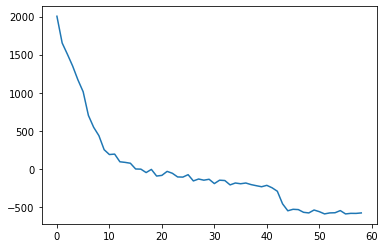

In [23]:
class HandWritingPredictionWithLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_mixtures):
        super(HandWritingPredictionWithLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_mixtures = num_mixtures
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size+input_size, hidden_size, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_size+input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(3*hidden_size, 6*num_mixtures+1)
        
    def forward(self, x, h0, c0):
        out1, _ = self.lstm1(x, (h0, c0))
        out2, _ = self.lstm2(torch.cat((x, out1), -1), (h0, c0))
        out3, _ = self.lstm3(torch.cat((x, out2), -1), (h0, c0))
        out4 = self.linear(torch.cat((out1, out2, out3), -1).reshape(-1, 3*hidden_size))
        return out4

input_size = 3
hidden_size = 500
batch_size = 1
n_mixtures = 1
m = HandWritingPredictionWithLSTM(input_size, hidden_size, n_mixtures).to(device)

def negative_log_likelihood(params, stroke_length, targets=None):   
    #print(params)
    es = 1/(1 + torch.exp(params[:,-1]))
    pis = nn.Softmax(1)(params[:,0:n_mixtures])
    mus = params[:, n_mixtures:3*n_mixtures].reshape(-1, n_mixtures, 2)
    sigmas = torch.exp(params[:, 3*n_mixtures:5*n_mixtures].reshape(-1, n_mixtures, 2))
    phos = torch.tanh(params[:, 5*n_mixtures:6*n_mixtures].reshape(-1, n_mixtures, 1))

    covs = torch.zeros(stroke_length-1, n_mixtures, 2, 2, device=device)
    tol = torch.tensor(0.000000001, device=device)
    covs[:,:,0,0] = sigmas[:,:,0] ** 2
    covs[:,:,0,1] = sigmas[:,:,0] * sigmas[:,:,1] * phos[:,:,0]
    covs[:,:,1,0] = covs[:,:,0,1]
    covs[:,:,1,1] = sigmas[:,:,1] ** 2

    
    distributions = torch.distributions.MultivariateNormal(mus, covs)
    
    target_coords = targets[:,0:2].unsqueeze(1).repeat_interleave(
        torch.tensor([n_mixtures], device=device), dim=1)
    stroke_lift = targets[:,-1]
    
    probs = torch.exp(distributions.log_prob(target_coords))
    #probs = torch.where(probs > 10, torch.zeros_like(probs) + 10, probs)
    probs = torch.where(probs < 0.000000001, torch.zeros_like(probs) + 0.000000001, probs)
#     print(torch.log((pis*probs).sum(dim=1)).sum())
#     print((torch.log(es)*stroke_lift).sum())
#     print((torch.log(1 - es)*(1-stroke_lift)).sum())

    loss = - (torch.log((pis*probs).sum(dim=1))).sum() - (torch.log(es)*stroke_lift).sum() - (torch.log(1 - es)*(1-stroke_lift)).sum()
    #print(loss)
    return loss


def train(model, input_stroke, stroke_len, optimizer, h0, c0):
    #     print(f"stroke: {input_stroke.shape}")
    #     print(f"stroke_len: {stroke_len}")
    #     print(f"h0: {h0.shape}")
    #     print(f"c0: {c0.shape}")
    optimizer.zero_grad()
    out = model(input_stroke[:,:stroke_len-1,:], h0, c0)
    loss = negative_log_likelihood(out, stroke_len, input_stroke[:,1:stroke_len,:].squeeze())
    loss.backward()
    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), 10)
    
    optimizer.step()
    return loss.item()

print_every = 500
n_epochs = 3
n_iters = 0
losses = []
total_loss = 0

optim = torch.optim.Adam(m.parameters(), lr = 0.00001)

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

h0=torch.zeros(batch_size, 1, hidden_size, device=device)
c0=torch.zeros(batch_size, 1, hidden_size, device=device)
he=torch.zeros(batch_size, 1, input_size, device=device)
ce=torch.zeros(batch_size, 1, input_size, device=device)

import time

start = time.time()

for i in range(n_epochs):
    for strokes, stroke_lens in train_dataloader:
        loss = train(
            model=m, 
            input_stroke=strokes.to(device),
            stroke_len=stroke_lens.item(),
            optimizer=optim,
            h0=h0, c0=c0)
        
        total_loss += loss
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs}, loss: {losses[-1]}, timeElapsed: {time.time() - start}")
            torch.save({
                    'epoch': i,
                    'model_state_dict': m.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'loss': losses[-1],
                    }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/model2.pt")
        n_iters += 1
        
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses[1:])

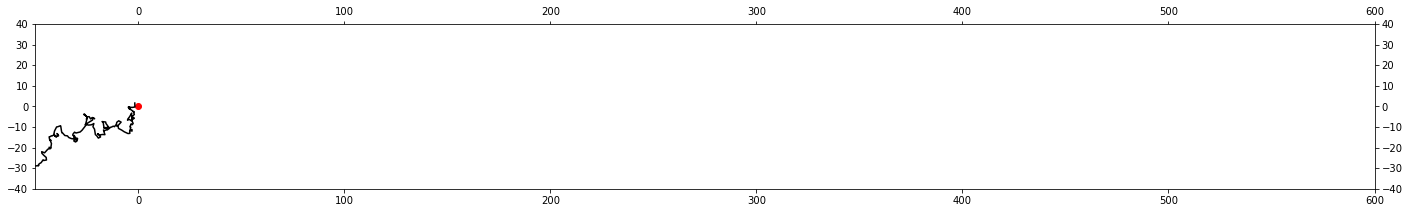

In [53]:
timestamps = 1200

with torch.no_grad():
    h0=torch.zeros(batch_size, 1, hidden_size, device=device)
    c0=torch.zeros(batch_size, 1, hidden_size, device=device)
    predictions = torch.zeros(timestamps, 3, device=device)
    predictions[0, 2] = 1
    for i in range(timestamps-1):
        inp = predictions[i].unsqueeze(0).unsqueeze(1)
        #print(inp.unsqueeze(0).unsqueeze(1))
        #print(h0.shape, c0.shape)
        
        out1, _ = m.lstm1(inp, (h0, c0))
        out2, _ = m.lstm2(torch.cat((inp, out1), -1), (h0, c0))
        out3, _ = m.lstm3(torch.cat((inp, out2), -1), (h0, c0))
        params = m.linear(torch.cat((out1, out2, out3), -1).reshape(-1, 3*hidden_size))

        #print(params)
        es = 1/(1 + torch.exp(params[:,-1]))
        pis = nn.Softmax(1)(params[:,0:n_mixtures])
        mus = params[:, n_mixtures:3*n_mixtures].reshape(-1, n_mixtures, 2)
        sigmas = torch.exp(params[:, 3*n_mixtures:5*n_mixtures].reshape(-1, n_mixtures, 2))
        phos = torch.tanh(params[:, 5*n_mixtures:6*n_mixtures].reshape(-1, n_mixtures, 1))

        covs = torch.zeros(n_mixtures, 2, 2, device=device)
        tol = torch.tensor(0.000000001, device=device)
        covs[:,0,0] = sigmas[:,:,0] ** 2
        covs[:,0,1] = sigmas[:,:,0] * sigmas[:,:,1] * phos[:,:,0]
        covs[:,1,0] = covs[:,0,1]
        covs[:,1,1] = sigmas[:,:,1] ** 2

        mixtures = torch.distributions.MultivariateNormal(mus, covs)
        sample = mixtures.sample().squeeze()
        predictions[i+1, 0] = sample[0]
        predictions[i+1, 1] = sample[1]
        predictions[i+1, 2] = 0#torch.bernoulli(es).item()

drawing.draw(predictions.cpu(), align_strokes=False, denoise_strokes=False)


In [35]:
a = 10000
b = 0
for i in range(a):
    b += torch.bernoulli(torch.tensor(0.9)).item()
b

8995.0

In [108]:
torch.set_printoptions(precision=10)
mus = torch.rand(22, 20, 2)
mus.shape
sigmas = torch.rand(22, 20, 2)
sigmas.shape
phos = torch.rand(22, 20, 1)
phos.shape
covs = torch.zeros(22, 20, 2, 2)
covs[:,:,0,0] = sigmas[:,:,0]**2
covs[:,:,1,1] = sigmas[:,:,1]**2

distributions = torch.distributions.MultivariateNormal(mus, covs)
print(distributions.batch_shape, distributions.event_shape)
targets = torch.rand(22, 2).unsqueeze(1)
targets = targets.repeat_interleave(torch.tensor([20]), dim=1)
targets.shape
lp = torch.exp(distributions.log_prob(targets))
lp.shape
wts = nn.Softmax(1)(torch.rand(22, 20))
wts.shape
lp[1,:]
wts[1,:]
(wts * lp)[1,:]
(wts * lp).shape

torch.Size([22, 20, 2])

torch.Size([22, 20, 2])

torch.Size([22, 20, 1])

torch.Size([22, 20]) torch.Size([2])


torch.Size([22, 20, 2])

torch.Size([22, 20])

torch.Size([22, 20])

tensor([2.3569624126e-01, 2.1319295466e-01, 3.6014885902e+00, 2.5937536359e-01,
        2.3509171009e+00, 1.8440544605e-01, 4.0873944759e-01, 1.0915555954e+00,
        1.0121872276e-01, 6.5111726522e-02, 3.0681800842e-01, 0.0000000000e+00,
        2.0708531141e-01, 1.6538779438e-01, 3.7418460846e-01, 1.7672851682e-02,
        4.0297690034e-01, 2.0239457954e-03, 1.9792731106e-01, 3.3254542351e+00])

tensor([0.0696100071, 0.0577052049, 0.0398469940, 0.0302223898, 0.0613434203,
        0.0288010295, 0.0389507748, 0.0417387374, 0.0657069981, 0.0568057299,
        0.0511838794, 0.0573577546, 0.0648760572, 0.0627077669, 0.0296213962,
        0.0419256724, 0.0491249934, 0.0397933759, 0.0569694042, 0.0557084493])

tensor([1.6406817362e-02, 1.2302342802e-02, 1.4350849390e-01, 7.8389430419e-03,
        1.4421328902e-01, 5.3110667504e-03, 1.5920717269e-02, 4.5560151339e-02,
        6.6507784650e-03, 3.6987191997e-03, 1.5704136342e-02, 0.0000000000e+00,
        1.3434878550e-02, 1.0371099226e-02, 1.1083870195e-02, 7.4094621232e-04,
        1.9796237350e-02, 8.0539633927e-05, 1.1275800876e-02, 1.8525590003e-01])

torch.Size([22, 20])

In [57]:
a = torch.tensor([[1, 2, 3], [1, 2, 3]])
a.shape
torch.sum(a, 0)
torch.sum(a, 1)

torch.Size([2, 3])

tensor([2, 4, 6])

tensor([6, 6])

In [ ]:
class HandWritingPredictionWithLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_mixtures):
        super(HandWritingPredictionWithLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_mixtures = num_mixtures
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size+input_size, hidden_size, batch_first=True)
        self.lstm3 = nn.LSTM(hidden_size+input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(3*hidden_size, 6*num_mixtures+1)
        
    def forward(self, x, h0, c0, he, ce):
        out1, _ = self.lstm1(x, (h0, c0))
        out2, _ = self.lstm2(torch.cat((x, out1), -1), (h0, c0))
        out3, _ = self.lstm3(torch.cat((x, out2), -1), (h0, c0))
        out4 = self.linear(torch.cat((out1, out2, out3), -1).reshape(-1, 3*hidden_size))
        return out4
    
    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, 1, self.hidden_size), torch.zeros(batch_size, 1, self.hidden_size)

def train(model, input_stroke, stroke_len, optimizer, loss_fnc, h0, c0, he, ce):
    #     print(f"stroke: {input_stroke.shape}")
    #     print(f"stroke_len: {stroke_len}")
    #     print(f"h0: {h0.shape}")
    #     print(f"c0: {c0.shape}")
    optimizer.zero_grad()
    out = model(input_stroke[:,:stroke_len-1,:], h0, c0, he, ce)
    #     print(out.shape)
    #     print(input_stroke[:,:stroke_len-1,:].shape)
    assert(out.shape == input_stroke[:,:stroke_len-1,:].shape)
    loss = loss_fnc(out, input_stroke[:,1:stroke_len,:])
    loss.backward()
    optimizer.step()
    return loss
    
input_size = 3
hidden_size = 500
batch_size = 1
m = HandWritingPredictionWithLSTM(input_size, hidden_size).to(device)
optim = torch.optim.Adam(m.parameters(), lr = 0.001)
loss_function = nn.MSELoss()

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

# s, l = next(iter(train_dataloader))
# loss = train(
#     model=m,
#     input_stroke=s.squeeze(dim=2).to(device),
#     stroke_len=l.item(),
#     optimizer=optim,
#     loss_fnc=loss_function,
#     h0=torch.zeros(batch_size, 1, hidden_size, device=device),
#     c0=torch.zeros(batch_size, 1, hidden_size, device=device),
#     he=torch.zeros(batch_size, 1, input_size, device=device),
#     ce=torch.zeros(batch_size, 1, input_size, device=device))

# torch.save({
#             'epoch': 2,
#             'model_state_dict': m.state_dict(),
#             'optimizer_state_dict': optim.state_dict(),
#             'loss': loss,
#             }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/model.pt")

print_every = 500
n_epochs = 10
n_iters = 0
losses = []
total_loss = 0

h0=torch.zeros(batch_size, 1, hidden_size, device=device)
c0=torch.zeros(batch_size, 1, hidden_size, device=device)
he=torch.zeros(batch_size, 1, input_size, device=device)
ce=torch.zeros(batch_size, 1, input_size, device=device)

for i in range(n_epochs):
    for strokes, stroke_lens in train_dataloader:
        loss = train(
            model=m, 
            input_stroke=strokes.to(device),
            stroke_len=stroke_lens.item(),
            optimizer=optim,
            loss_fnc=loss_function,
            h0=h0, c0=c0, he=he, ce=ce)
        
        total_loss += loss
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs}, loss: {losses[-1]}")
            torch.save({
                    'epoch': i,
                    'model_state_dict': m.state_dict(),
                    'optimizer_state_dict': optim.state_dict(),
                    'loss': losses[-1],
                    }, "/u/home/lyrebird_code/handwriting_synthesis/model_checkpoints/model.pt")
        n_iters += 1
        
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses[1:])

cuda:0
n_iter: 0 of 100000, loss: 0.005060491617769003
n_iter: 500 of 100000, loss: 2.415259599685669
n_iter: 1000 of 100000, loss: 2.262423038482666
n_iter: 1500 of 100000, loss: 2.371595621109009
n_iter: 2000 of 100000, loss: 2.354013681411743
n_iter: 2500 of 100000, loss: 2.2823498249053955
n_iter: 3000 of 100000, loss: 2.38505482673645
n_iter: 3500 of 100000, loss: 2.282252788543701
n_iter: 4000 of 100000, loss: 2.2105233669281006
n_iter: 4500 of 100000, loss: 2.300356864929199
n_iter: 5000 of 100000, loss: 2.3190813064575195
n_iter: 5500 of 100000, loss: 2.31321120262146
n_iter: 6000 of 100000, loss: 2.2912728786468506
n_iter: 6500 of 100000, loss: 2.245999336242676
n_iter: 7000 of 100000, loss: 2.1940739154815674
n_iter: 7500 of 100000, loss: 2.3092567920684814
n_iter: 8000 of 100000, loss: 2.29649019241333
n_iter: 8500 of 100000, loss: 2.299196720123291
n_iter: 9000 of 100000, loss: 2.2537505626678467
n_iter: 9500 of 100000, loss: 2.3710782527923584
n_iter: 10000 of 100000, loss

In [47]:
timestamps = 1200
with torch.no_grad():
    h0=torch.zeros(batch_size, 1, hidden_size, device=device)
    c0=torch.zeros(batch_size, 1, hidden_size, device=device)
    he=torch.zeros(batch_size, 1, input_size, device=device)
    ce=torch.zeros(batch_size, 1, input_size, device=device)
    predictions = torch.zeros(timestamps, 3, device=device)
    predictions[0, 2] = 1
    for i in range(timestamps-1):
        inp = predictions[i]
        #print(inp.unsqueeze(0).unsqueeze(1))
        #print(h0.shape, c0.shape)
        output, (h0, c0) = m.lstm1(inp.unsqueeze(0).unsqueeze(1), (h0, c0))
        #print(output.shape, h0.shape, c0.shape)
        output, (he, ce) = m.lstm_out(h0, (he, ce))
        #print(output.shape, he.shape, ce.shape)
        predictions[i+1] = he.reshape(-1)
    

    
# start = torch.tensor([0, 0, 1], dtype=torch.float32, device=device)
# with torch.no_grad():
#     a = m(start.unsqueeze(0).unsqueeze(1), h0, c0, he, ce)
# print(a.shape)
# #a[:, :, 2] = a[:, :, 2] > 0.0000001
# #a
# a.reshape(-1)
# a

tensor([[ 0.0000e+00,  0.0000e+00,  1.0000e+00],
        [-1.0651e-01, -1.8280e-01,  1.0190e-07],
        [-2.6253e-01, -3.6974e-01, -2.2414e-06],
        ...,
        [ 1.2201e-02,  3.6043e-02,  9.5921e-03],
        [ 2.0965e-02,  3.4605e-02,  2.9063e-04],
        [ 1.1853e-02,  4.5208e-02,  1.2749e-04]], device='cuda:0')

/tmp/ipykernel_326/3247567841.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  predictions_th = torch.tensor(predictions)


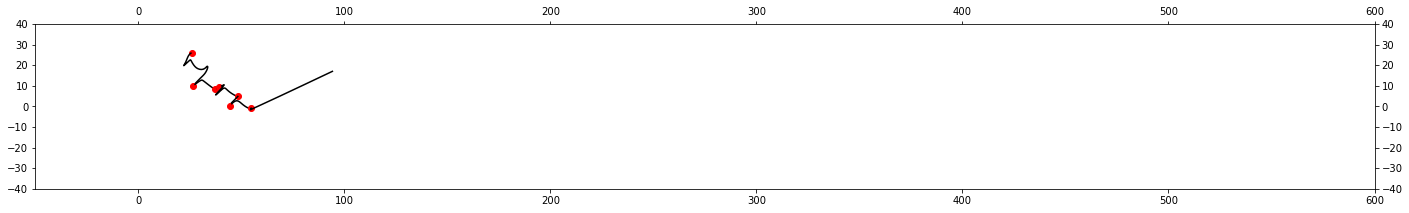

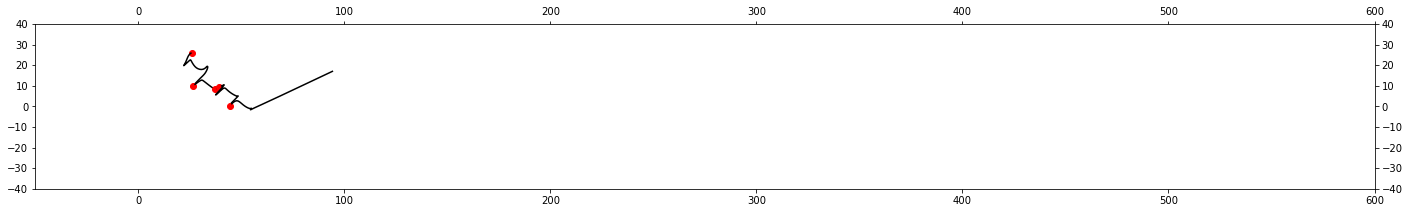

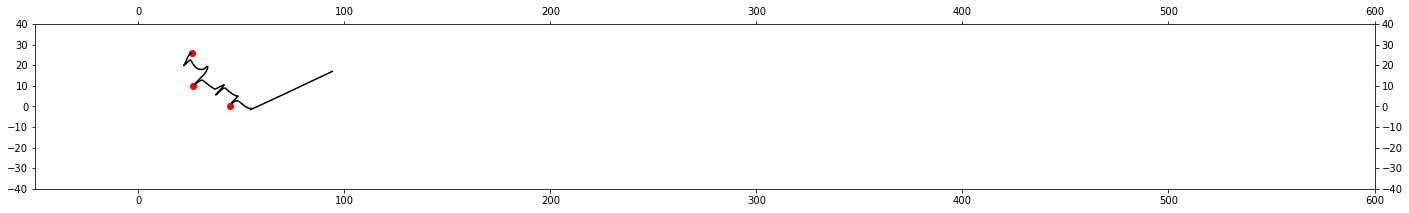

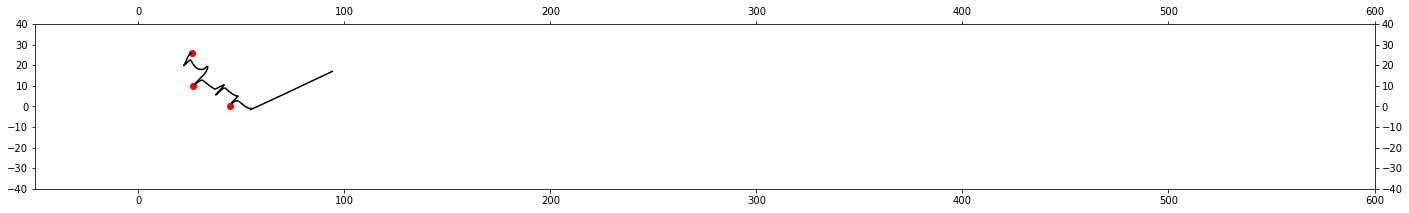

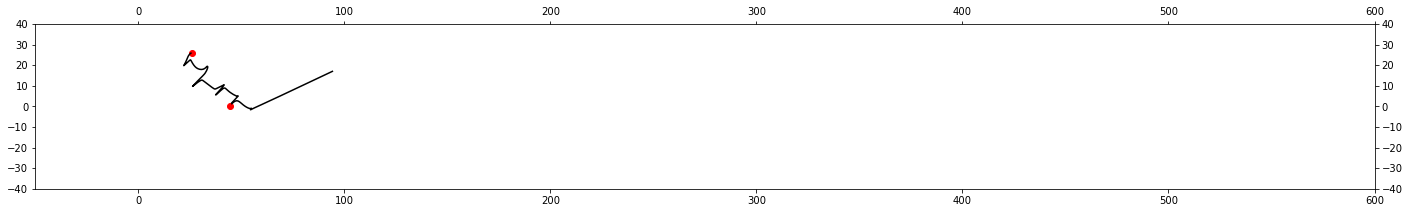

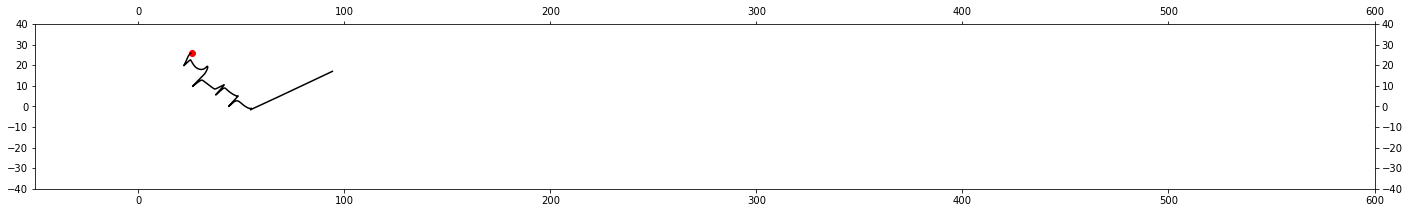

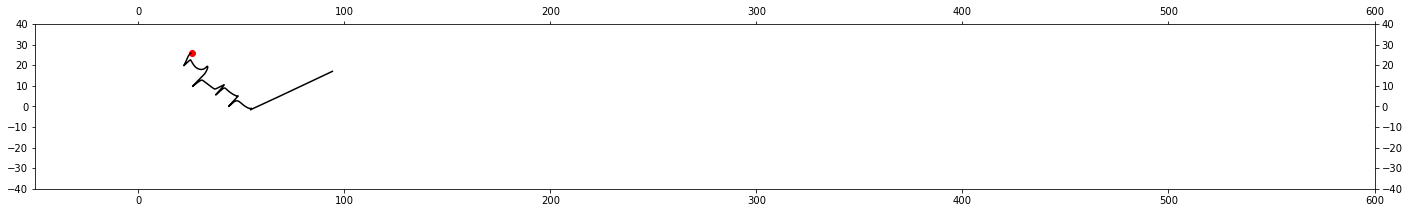

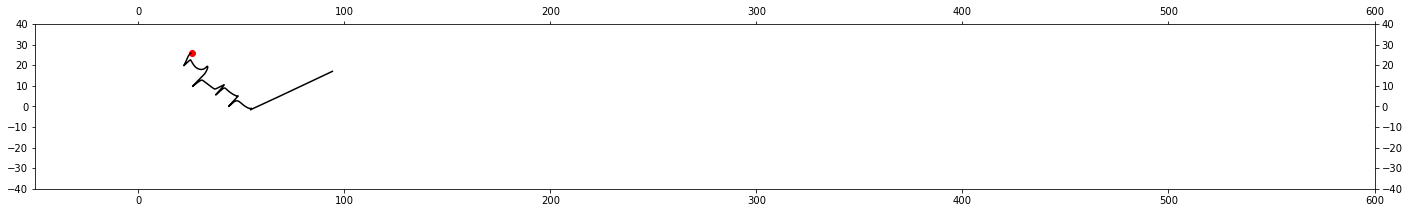

In [48]:
predictions

for threshold in np.arange(0.1, 0.9, 0.1):
    predictions_th = torch.tensor(predictions)
    predictions_th[:, 2] = predictions_th[:, 2] > threshold
    drawing.draw(predictions_th.cpu(), align_strokes=True, denoise_strokes=True)


In [ ]:
def sample(model, predictions):
    with torch.no_grad():
        start = predictions[0]
        for i in range(len(predictions)-1):
            print(model(start.unsqueeze_(0), h0, ).shape()) 
    

In [13]:
class LSTMExp(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMExp, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        
    def forward(self, x, h0, c0):
        return self.lstm(x, (h0, c0))
    
input_size = 3
seq_length = 12
hidden_size = 100
batch_size = 10
x = torch.rand(batch_size, seq_length, input_size)
h0 = torch.rand(1, batch_size, hidden_size)
c0 = torch.rand(1, batch_size, hidden_size)
m = LSTMExp(input_size, hidden_size)
out, (hn, cn) = m(x, h0, c0)
print(out.shape)
print(hn.shape)
print(cn.shape)

torch.save({
            'epoch': 2,
            'model_state_dict': m.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': losses[-1],
            }, "model_checkpoints/")

torch.Size([10, 12, 100])
torch.Size([1, 10, 100])
torch.Size([1, 10, 100])


In [46]:
MAX_SEQ_LENGTH = 1200

class HandWritingPrediction(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(HandWritingPrediction, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.lstmCell1 = nn.LSTMCell(input_size, hidden_size)
        self.lstmCell2 = nn.LSTMCell(hidden_size + input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, input_size)
        self.num_activations = 4 # 2 for each lstm layers
    
    def forward(self, x, activations, idx):
        activations_new[0], activations_new[1] = self.lstmCell1(
            x, (activations_old[0], activations_old[1]))
        activations_new[2], activations_new[3] = self.lstmCell2(
            torch.cat((x, activations_old[2]), 1), (aactivations_old[2], activations_old[3]))
        out = self.linear(activations_old[2])
        return out, activations_old, activations_new
    
    def init_hidden(self, bs, device):
        return torch.zeros(self.num_activations, bs, self.hidden_size).to(device)


In [40]:
def train(model, input_stroke, stroke_len, optimizer, loss_fnc, activations1, activations2):
    optimizer.zero_grad()
    bs = 1
    loss = 0
    for i, pt in enumerate(input_stroke[:stroke_len-1]):
        out, activations = model(pt, activations1, activations2)
        loss += loss_fnc(out, input_stroke[i+1])
    loss = loss/(stroke_len-1)
    loss.backward()
    optimizer.step()
    return loss

In [41]:
def eval(model, input_stroke, stroke_len, loss_fnc, activations):
    with torch.no_grad():
        bs = 1
        loss = 0
        for i, pt in enumerate(input_stroke[:stroke_len-1]):
            out, activations = model(pt, activations, i)
            loss += loss_fnc(out, input_stroke[i+1])
        loss = loss/len(inputs)
        return loss

In [42]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [43]:
batch_size = 1
n_hidden = 1000
n_input = 3

model = HandWritingPrediction(n_input, n_hidden).to(device)
optim = torch.optim.Adam(model.parameters(), lr = 0.001)
loss_function = nn.MSELoss()

    



In [45]:
print_every = 100
n_epochs = 2
n_iters = 0
losses = []
total_loss = 0
activations = model.init_hidden(batch_size, device)

torch.autograd.set_detect_anomaly(True)

for i in range(n_epochs):
    for strokes, stroke_lens in train_dataloader:
        loss = train(model, strokes[0].to(device), stroke_lens.item(), optim, loss_function, activations)
        activations.zero_()
        total_loss += loss
        if n_iters % print_every == 0:
            losses.append(total_loss/print_every)
            total_loss = 0
            print(f"n_iter: {n_iters} of {len(train_dataloader)*n_epochs}, loss: {losses[-1]}")
        n_iters += 1

[W python_anomaly_mode.cpp:104] Warning: Error detected in ThnnFusedLstmCellBackward. Traceback of forward call that caused the error:
  File "/home/miniconda3/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/miniconda3/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/miniconda3/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/miniconda3/lib/python3.8/site-packages/traitlets/config/application.py", line 845, in launch_instance
    app.start()
  File "/home/miniconda3/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 667, in start
    self.io_loop.start()
  File "/home/miniconda3/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/home/miniconda3/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
    self._run_once()
  Fil

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [1, 1000]], which is output 0 of AsStridedBackward, is at version 2049; expected version 2047 instead. Hint: the backtrace further above shows the operation that failed to compute its gradient. The variable in question was changed in there or anywhere later. Good luck!

<Figure size 432x288 with 0 Axes>

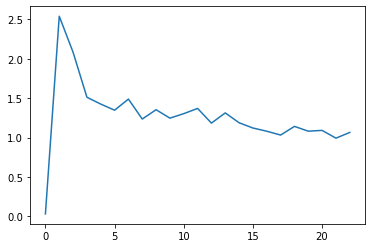

In [38]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(losses)

In [90]:
from torch.nn.utils.rnn import pack_padded_sequence
s, l = next(iter(train_dataloader))
s.shape
l.shape
#packed = pack_padded_sequence(s, l, batch_first=True, enforce_sorted=False)

#model(packed, h, c)

torch.Size([1, 1200, 3])

torch.Size([1])

In [96]:
eval(model, s[0], l.item(), loss_function)

torch.Size([702, 1, 3])
torch.Size([702, 1, 3])
torch.Size([1, 1000])


tensor(3.1328)